In [128]:
import pandas as pd
import numpy as np
import re
from functools import reduce

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec
import textwrap

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

from scipy.stats import norm

pd.options.display.max_columns=None
pd.options.display.max_colwidth=310
pd.options.mode.chained_assignment=None

In [2]:
# Dataset completo procesado
ruta='data/formacion_procesado.csv'
df=pd.read_csv(ruta,index_col=0,low_memory=False)
df.shape

(73513, 426)

In [3]:
# Dataset ocupados: 
df_oc=df[df['ocupacion'].notna()]

In [4]:
# Diccionario de diccionarios de variables target (etiquetado resultados de regresión logística): 
D_target=dict()

In [5]:
# Diccionario de ocupaciones para interpretación de resultados de regresión logística:
D_target['ocupacion']=dict(zip(df_oc['ocupacion'].unique(),df_oc['ocupacion_'].unique()))

In [6]:
# Diccionario de sectores cnae para interpretación de resultados de regresión logística:
D_target['cnae']=dict(zip(df_oc['cnae'].unique(),df_oc['cnae_'].unique()))

# Funciones instrumentales básicas

### Codificador binario: one_hot_pipe



In [7]:
def one_hot_pipe(fit_data,just_transform=[],columns=None,prefix=None,prefix_sep='_',
                 drop_first=False, keep_columns=[]):
    
    """ Pipe del fit and transform de one_hot_encoder de sklearn al estilo de pd.getdummies: las columnas a 
    codificar quedan sustituidas en el dataset por las nuevas columnas binarias, nombradas como la categoría a la 
    que están asociadas. 
    
    Ventaja respecto a un pipe basado en pd.get_dummies:
    1. Garantiza que las columnas nuevas en validación y en test (proceso transform) son todas las asociadas a las 
    categorías observadas en train y solo esas (no apararecen nuevas columnas binarias en validación o test).
    
    Dataset como argumentos: 
        - fit_data: dataset para proceso fit: determina las categorías para las que se crean columnas binarias
        - just_transform (opcional): ldatasets solo para transformación de acuerdo con el criterio definido 
        en fit. Si son varios, deben pasarse como lista. 
        
    Resultado: datasets (fit_data y los añadidos en just_transform) transformados. Formato tupla. 
    
    Argumento keep_columns: 
    El argumento keep_columns permite decidir si se prescinde de las columnas categóricas una vez codificadas en 
    columnas binarias o se conservan. Por defecto, se prescinde de todas. Si keep_columns es True, se conservan
    todas. Si keep_columns es una lista boolena, se conservan las que que estén en la misma posición que los 
    valores True. 
    """
 
    # Datasets solo para transformar, como lista:
    if type(just_transform)!=list: just_transform=[just_transform]
    
    # Datasets para proceso transform: 
    transform=[fit_data]+just_transform
    
    # Argumento keep_columns, por defecto, False para todas las columnas a codificar: 
    if keep_columns==[]: keep_columns=[False]*len(columns)
    # Si True, mismo valor para todas las columnas:
    elif keep_columns==True: keep_columns=[True]*len(columns)
    
    for i,col in enumerate(columns): 
        
        # sklearn fit: 
        encoder=OneHotEncoder(handle_unknown='ignore').fit(fit_data[[col]])
        cats=encoder.categories_[0].tolist()
        
        # sklearn transform:         
        for n,data in enumerate(transform): 
            
            # Indices para recuperar más adelante: 
            idx=pd.DataFrame({'index':data.index})
            
            aux=pd.DataFrame(encoder.transform(data[[col]]).toarray())
        
            # Recupera índices: 
            aux=aux.merge(idx,left_index=True,right_index=True)
            aux.set_index('index',inplace=True)
            aux.index.rename(None,inplace=True)
        
            # Nombres de columnas: 
            if type(prefix)==list: prefijo=prefix[i] 
            else: prefijo=prefix 
            if prefijo is None: prefijo=''
            nombres=map(lambda cat: prefijo+prefix_sep+str(cat),cats)
            aux.rename(columns=dict(zip(aux.columns,nombres)),inplace=True)
        
            # Drop_first: 
            if type(drop_first)==list: drop=drop_first[i]
            else: drop=drop_first
            if drop==True: del aux[aux.columns[0]]
            
            data=data.merge(aux,left_index=True,right_index=True)
            
            # Prescinde de columna codificada si keep_columns[i]=False: 
            if keep_columns[i]==False: del data[col]
                
            transform[n]=data

    # Salida como tupla si contiene más de un dataset:        
    out=tuple(transform)
  
    # Salida si solo un dataset: 
    if len(out)==1:
        out=out[0]
    
    return out

### Función report

Transforma el classificacion_report facilitado por sklearn en un dataframe de Pandas: 
 
- Traduce los códigos numéricos de las categorías del target a sus valores literales
- Ordena las categorías del target por recall (orden creciente)
- Prescinde de las métricas no ponderadas y micro
- Permite comparar con los resultados de distintos modelos. 

In [8]:
def report(modelo,data_regresores,data_target,compara=None,name=None):
    """ Da estuctura de dataframe al infotme de clasificación proporcionado por la herramienta estándar de sklearn.
    """
    global D_target,target,X_train,X_vld,X_test,y_train,y_vld,y_test
    
    report=classification_report(data_target,modelo.predict(data_regresores),
                                 zero_division=0,
                                 labels=[k for k in D_target[target].keys()],
                                 target_names=[k for k in D_target[target].values()],
                                 output_dict=True)

    report=pd.DataFrame(report)
    orden_recall=report[report.columns[:-3]].sort_values(by=report.index[1],axis=1,ascending=False).columns
    report=report.reindex([report.columns[-1]]+orden_recall.tolist(),axis=1)
    if name==None: name=''
    D_report=dict(zip(report.index,map(lambda string: string+' '+name,report.index)))
    report=pd.DataFrame(report).rename(index=D_report)
    
    if compara is not None: 
        report=compara.append(report)
    
    return report

# Modelo ocupación sobre título principal (regresor único): codificación binaria

Se especifica un modelo con el título principal como regresor único para conocer en qué medida este explica por sí solo las ocupaciones de los encuestados. 

Sirve como referencia de comparación para el resto de modelos que incluyan otros regresores u otros métodos de codificación o tratamiento de las variables. 

In [9]:
df_m=df[['ocupacion','titulo_ppal_']].dropna()

n_oc=df_m['ocupacion'].nunique()
n_tt=df_m['titulo_ppal_'].nunique()
print (f'{n_oc} ocupaciones distintas, {n_tt} títulos distintos en el dataset.')

62 ocupaciones distintas, 173 títulos distintos en el dataset.


In [10]:
# Modelo RU (regresor único): 

target='ocupacion'

df_m=df[['ocupacion','titulo_ppal_']].dropna()
y=df_m['ocupacion']
X=df_m[['titulo_ppal_']]
# Train_validación_test split estratificado según presencia de títulos en la muestra: 
X_train,X_complementario,y_train,y_complementario=train_test_split(X,y,test_size=0.4,random_state=23,
                                                                  stratify=df_m['titulo_ppal_'])
X_vld,X_test,y_vld,y_test=train_test_split(X_complementario,y_complementario,test_size=0.5,random_state=23,
                                           stratify=X_complementario)
# Codificación binaria de títulos:
# (se aplica sobre las columnas literales para facilitar la interpretación de las columnas resultantes)
X_train,X_vld,X_test =one_hot_pipe(fit_data=X_train,just_transform=[X_vld,X_test],columns=['titulo_ppal_'],
                                   prefix='',prefix_sep='')

# LR sin ordenada en el origen para evitar colinealidad (dummy para todos los títulos)
modelo_RU=LogisticRegression(solver='newton-cg',max_iter=200,fit_intercept=False).fit(X_train,y_train)

In [11]:
# Resultados modelo RU en train: 
report_RU_train=report(modelo_RU,X_train,y_train,name='RU train')
report_RU_train

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales TI,Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos sanitarios y laboratorio,"Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Empleados administrativos sin atención al público,Representantes e intermediarios,"Trabajadores ind alimentación, bebidas y tabaco",Ocupaciones militares,Vendedores excepto comercio,Trabajadores cualificados agricultura,Cajeros y taquilleros excepto bancos,Maquinistas de equipos pesados móviles,Mecánicos y ajustadores de maquinaria,"Trabajadores madera, textil, confección, piel y cuero",Trabajadores cualificados ganadería,Empleados domésticos,Profesionales de apoyo finanzas y matemáticas,"Peones agrarios, forestales y pesca",Operadores de instalaciones y maquinaria fija,Peones de construcción y minería,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,Trabajadores construcción y afines: estructura,"Mecánicos de precisión, artesanos y artes gráficas","Supervisores ingeniería, industria y construcción",Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados act. agropecuaria,"Soldadores, chapistas, montadores de estructuras",Recogedores residuos urbanos y ocupaciones elementales servicios,Comerciantes propietarios de tiendas,Directores producción y operaciones,Otros empleados administrativos con atención al público,Trabajadores servicios personales,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Técnicos TI,Trabajadores servicios de cuidados de salud,Gerentes hostelería y comercio,Dependientes de comercio,Trabajadores servicios de cuidados no de salud,Ayudantes de preparación de alimentos,Profesionales de apoyo a la gestión administrativa,Personal de limpieza de establecimientos y vehículos,Directores Admón y comerciales,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Profesionales de la eduación especial y no reglada,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision RU train,0.343813,0.814701,0.435991,0.489837,0.435696,0.389813,0.271129,0.297228,0.260937,0.273026,0.398276,0.166113,0.223451,0.321429,0.301205,0.189474,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall RU train,0.452682,0.878949,0.791702,0.738509,0.715517,0.586050,0.573012,0.510582,0.484058,0.268608,0.254967,0.183150,0.171283,0.139860,0.125628,0.018711,0.009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score RU train,0.375183,0.845606,0.562315,0.589002,0.541599,0.468201,0.368090,0.375730,0.339086,0.270799,0.310902,0.174216,0.193920,0.194911,0.177305,0.034059,0.018935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support RU train,35906.000000,4527.000000,4676.000000,5874.000000,928.000000,1319.000000,1534.000000,1134.000000,690.000000,618.000000,906.000000,273.000000,1769.000000,1287.000000,398.000000,962.000000,813.000000,35.0,102.0,118.0,73.0,95.0,41.0,31.0,18.0,19.0,11.0,99.0,50.0,89.0,23.0,36.0,15.0,25.0,32.0,181.0,16.0,1

### Observaciones: 

- Solo 16 ocupaciones de las 61 recogidas en el conjunto de train tienen métricas positivas. Hay 45 ocupaciones para las que todas las métricas son nulas incluso en la evaluación en train. 


- Las ocupaciones con **recall nulo** son profesiones que requieren una cualificación que no es universitaria con las siguientes **excepciones**: 

    - **Técnicos TI**, cuya formación especializada puede ser universitaria o de ciclos superiores de Formación Profesional. El número de titulados en la encuesta con esta ocupación sí es significativo. 
    
    - **Política y direccón de la Administración pública**, cuya denominación completa es 'Miembros del poder ejecutivo y de los cuerpos legislativos; directivos de la Administración Pública y organizaciones de interés social; directores ejecutivos'. Está compuesta por los representantes públicos electos en los distintos niveles de la Administración, secretarios y subsecretarios de Estado, los miembros del CGPJ y del cuerpo diplomático, dirigentes de partidos políticos, sindicatos, organizaciones empresariales, fundaciones y organizaciones humanitarias, directores generales de empresas públicas y privadas, directores ejecutivos y rectores de universidades(*). La razón para la falta de acierto en la predicción de estas ocupaciones puede ser la hetereogeneidad de las cualificiones académicas necesarias para ejercerlas (desde ninguna en particular para ser representante público o cargo de confianza de estos hasta la excelencia profesional o académica exigida a los miembros del CGPJ o los rectores de universidades) y el número muy pequeño de puestos de trabajo que representan estas ocupaciones sobre el total de la población ocupada. El número de titulados en la encuesta con esta ocupación no es significativo. 
    
    - **Profesionales de la educación especial y no reglada**, que incluye desde profesores de educación especial con una formación muy especializada hasta profesores y técnicos de eduación no reglada de idiomas, música, artes, informática y educación ambiental, profesores de apoyo (particulares o academias) y orientadores escolares. El número de titulados en la encuesta con esta ocupación sí es significativo. 
    
(*) Fuente: https://www.ine.es/daco/daco42/clasificaciones/cno11_notas.pdf

In [12]:
# Numero de titulados (encuesta completa) con la ocupación Política y dirección Admón Pública:
df_oc[df_oc['ocupacion_']=='Política y dirección Admón Pública']['ocupacion_'].count()

280

In [13]:
# Numero de titulados (encuesta completa) con la ocupación Técnicos TI:
df_oc[df_oc['ocupacion_']=='Técnicos TI']['ocupacion_'].count()

1662

In [14]:
# Numero de titulados (encuesta completa) con la ocupación Profesionales de la eduación especial y no reglada:
df_oc[df_oc['ocupacion_']=='Profesionales de la eduación especial y no reglada']['ocupacion_'].count()

1768

In [15]:
# Modelo regresor único: resultados comparados en train y validación: 
report(modelo_RU, X_vld, y_vld,report_RU_train,name='RU vld')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales TI,Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos sanitarios y laboratorio,"Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Empleados administrativos sin atención al público,Representantes e intermediarios,"Trabajadores ind alimentación, bebidas y tabaco",Ocupaciones militares,Vendedores excepto comercio,Trabajadores cualificados agricultura,Cajeros y taquilleros excepto bancos,Maquinistas de equipos pesados móviles,Mecánicos y ajustadores de maquinaria,"Trabajadores madera, textil, confección, piel y cuero",Trabajadores cualificados ganadería,Empleados domésticos,Profesionales de apoyo finanzas y matemáticas,"Peones agrarios, forestales y pesca",Operadores de instalaciones y maquinaria fija,Peones de construcción y minería,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,Trabajadores construcción y afines: estructura,"Mecánicos de precisión, artesanos y artes gráficas","Supervisores ingeniería, industria y construcción",Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados act. agropecuaria,"Soldadores, chapistas, montadores de estructuras",Recogedores residuos urbanos y ocupaciones elementales servicios,Comerciantes propietarios de tiendas,Directores producción y operaciones,Otros empleados administrativos con atención al público,Trabajadores servicios personales,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Técnicos TI,Trabajadores servicios de cuidados de salud,Gerentes hostelería y comercio,Dependientes de comercio,Trabajadores servicios de cuidados no de salud,Ayudantes de preparación de alimentos,Profesionales de apoyo a la gestión administrativa,Personal de limpieza de establecimientos y vehículos,Directores Admón y comerciales,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Profesionales de la eduación especial y no reglada,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision RU train,0.343813,0.814701,0.435991,0.489837,0.435696,0.389813,0.271129,0.297228,0.260937,0.273026,0.398276,0.166113,0.223451,0.321429,0.301205,0.189474,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall RU train,0.452682,0.878949,0.791702,0.738509,0.715517,0.586050,0.573012,0.510582,0.484058,0.268608,0.254967,0.183150,0.171283,0.139860,0.125628,0.018711,0.009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score RU train,0.375183,0.845606,0.562315,0.589002,0.541599,0.468201,0.368090,0.375730,0.339086,0.270799,0.310902,0.174216,0.193920,0.194911,0.177305,0.034059,0.018935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support RU train,35906.000000,4527.000000,4676.000000,5874.000000,928.000000,1319.000000,1534.000000,1134.000000,690.000000,618.000000,906.000000,273.000000,1769.000000,1287.000000,398.000000,962.000000,813.000000,35.0,102.0,118.0,73.0,95.0,41.0,31.0,18.0,19.0,11.0,99.0,50.0,89.0,23.0,36.0,15.0,25.0,32.0,181.0,16.0,1

### Observaciones: 

- No hay sobreajuste: la evaluación de los resultados en train y test es muy similar. 


- Solo una de las ocupaciones con métricas positivas en train tiene todas las métricas nulas al evaluar el modelo sobre el conjunto de validación: son los Representantes e intermediarios. Por tanto, solo hay 15 ocupaciones con métricas positivas en validación. 

In [16]:
# Modelo RU: resultados en validacion (para comparaciones posteriores)
report_RU_vld=report(modelo_RU, X_vld, y_vld,name='RU vld')
report_RU_vld

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,"Empleados servicios financieros, contables y de apoyo",Profesionales de las ciencias sociales,Profesionales TI,Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos","Expertos en gestión, finanzas, comercio, etc",Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,Técnicos ciencias e ingenierías,Empleados administrativos sin atención al público,Ocupaciones militares,"Trabajadores ind alimentación, bebidas y tabaco",Maquinistas de equipos pesados móviles,Trabajadores cualificados agricultura,Vendedores excepto comercio,Cajeros y taquilleros excepto bancos,Mecánicos y ajustadores de maquinaria,"Trabajadores madera, textil, confección, piel y cuero",Trabajadores cualificados ganadería,Empleados domésticos,Profesionales de apoyo finanzas y matemáticas,"Peones agrarios, forestales y pesca",Operadores de instalaciones y maquinaria fija,Peones de construcción y minería,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,Trabajadores construcción y afines: estructura,"Mecánicos de precisión, artesanos y artes gráficas","Supervisores ingeniería, industria y construcción",Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados act. agropecuaria,"Soldadores, chapistas, montadores de estructuras",Recogedores residuos urbanos y ocupaciones elementales servicios,Comerciantes propietarios de tiendas,Ayudantes de preparación de alimentos,Otros empleados administrativos con atención al público,Trabajadores servicios personales,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Técnicos TI,Trabajadores servicios de cuidados de salud,Gerentes hostelería y comercio,Dependientes de comercio,Representantes e intermediarios,Directores producción y operaciones,Trabajadores servicios de cuidados no de salud,Profesionales de apoyo a la gestión administrativa,Personal de limpieza de establecimientos y vehículos,Directores Admón y comerciales,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Profesionales de la eduación especial y no reglada,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision RU vld,0.336418,0.813153,0.442797,0.492031,0.454724,0.272643,0.358548,0.288136,0.222482,0.359606,0.455959,0.213656,0.309091,0.120000,0.252688,0.187500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall RU vld,0.452252,0.882000,0.792167,0.735801,0.733333,0.566219,0.549884,0.520891,0.441860,0.324444,0.315412,0.161667,0.141667,0.125000,0.121762,0.018127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score RU vld,0.374685,0.846178,0.568063,0.589718,0.561361,0.368060,0.434066,0.371032,0.295950,0.341121,0.372881,0.184061,0.194286,0.122449,0.164336,0.033058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support RU vld,11969.000000,1500.000000,1583.000000,1972.000000,315.000000,521.000000,431.000000,359.000000,215.000000,225.000000,279.000000,600.000000,120.000000,96.000000,386.000000,331.000000,40.0,17.0,14.0,20.0,39.0,47.0,9.0,8.0,4.0,2.0,35.0,14.0,28.0,5.0,8.0,5.0,8.0,8.0,69.0,6.0,1.0,4.0,21.0,4.0,4.0,224.0,101.0,35.0,25.0,133.0,359.0

### Lista de ocupaciones 'recall_nulo'

Se guardan las ocupaciones con recall nulo en el modelo con regresor único para comprobar si mejoran sus métricas al añadir regresores adicionales. 

In [17]:
def metricas_nulas(report,fila_recall_vld):
    
    """ Lista de ocupaciones con métricas nulas en el modelo asociado al informe report. 
    Argumento fila_recall_train: identifica la posición de la fila de recall en el informe de evaluación en 
    validación para identificar métricas nulas (si el recall es nulo, no hay ningún acierto y todas las métricas 
    son nulas). 
    """
    out=list()
    for col in report.columns[1:]:
        if report[col].iloc[fila_recall_vld]==0:
            out.append(col)
    
    return out

In [18]:
metricas_nulas_RU=metricas_nulas(report_RU_vld,1)
metricas_nulas_RU

['Ocupaciones militares',
 'Trabajadores ind alimentación, bebidas y tabaco',
 'Maquinistas de equipos pesados móviles',
 'Trabajadores cualificados agricultura',
 'Vendedores excepto comercio',
 'Cajeros y taquilleros excepto bancos',
 'Mecánicos y ajustadores de maquinaria',
 'Trabajadores madera, textil, confección, piel y cuero',
 'Trabajadores cualificados ganadería',
 'Empleados domésticos',
 'Profesionales de apoyo finanzas y matemáticas',
 'Peones agrarios, forestales y pesca',
 'Operadores de instalaciones y maquinaria fija',
 'Peones de construcción y minería',
 'Camareros y cocineros propietarios',
 'Montadores y ensambladores en fábricas',
 'Trabajadores construcción y afines: estructura',
 'Mecánicos de precisión, artesanos y artes gráficas',
 'Supervisores ingeniería, industria y construcción',
 'Trabajadores construcción e instalaciones: acabado',
 'Trabajadores cualificados act. agropecuaria',
 'Soldadores, chapistas, montadores de estructuras',
 'Recogedores residuos u

In [19]:
len(metricas_nulas_RU)

47

## Modelo regresor único con filtro 'utilidad'

La columna 'utilidad' (binaria) identifica a los encuestados que manifiestan que su título universitario les ha sido útil para encontrar empleo. 

No debe emplearse como regresor para predecir la ocupación de un titulado porque es una información inseparable del empleo que se pretende predecir. 

Se propone un filtro basado en la columna 'utilidad': cuando se activa, el modelo se entrena en un subconjunto del conjunto de train formado solo por las observaciones para las que la columna utilidad toma valor 1. No modifica los conjuntos de validación ni de test. 

El filtro de 'utilidad' implica una reducción en tamaño del conjunto de train. A cambio, selecciona solo las observaciones para las que sí hay relación entre el la formación y la ocupación del encuestado. Es de esperar que mejore las métricas de las ocupaciones para las que la formación universitaria es más determinante y que reduzca la capacidad predictiva del modelo para las ocupaciones que requieren otro tipo de formación que no es universitaria. 

In [20]:
# Modelo de regresor único con filtro 'utilidad':

target='ocupacion'

df_m=df[df['ocupacion'].notna()]
y=df_m[['ocupacion','utilidad']]
X=df_m[['titulo_ppal_','utilidad']]

# Train_validación_test split estratificado según presencia de títulos en la muestra: 
X_train,X_complementario,y_train,y_complementario=train_test_split(X,y,test_size=0.4,random_state=23,
                                                                  stratify=df_m['titulo_ppal_'])
X_vld,X_test,y_vld,y_test=train_test_split(X_complementario,y_complementario,test_size=0.5,random_state=23,
                                           stratify=X_complementario['titulo_ppal_'])
# Codificación binaria de títulos:
X_train,X_vld,X_test =one_hot_pipe(fit_data=X_train,just_transform=[X_vld,X_test],columns=['titulo_ppal_'],
                                   prefix='',prefix_sep='')

# Filtro utilidad:
X_train=X_train[X_train['utilidad']==1]
y_train=y_train[y_train['utilidad']==1]
del X_train['utilidad'],X_vld['utilidad'],X_test['utilidad']
y_train=y_train['ocupacion']
y_vld=y_vld['ocupacion']
y_test=y_test['ocupacion']

# LR sin ordenada en el origen para evitar colinealidad (dummy para todos los títulos)
modelo_RU_u1=LogisticRegression(solver='newton-cg',max_iter=200,fit_intercept=False).fit(X_train,y_train)

In [21]:
# Modelos con regresor único en train: comparación con y sin filtro utilidad: 

report(modelo_RU_u1,X_train,y_train,report_RU_train,name='RU u1 train')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales TI,Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos sanitarios y laboratorio,"Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Empleados administrativos sin atención al público,Representantes e intermediarios,"Trabajadores ind alimentación, bebidas y tabaco",Ocupaciones militares,Vendedores excepto comercio,Trabajadores cualificados agricultura,Cajeros y taquilleros excepto bancos,Maquinistas de equipos pesados móviles,Mecánicos y ajustadores de maquinaria,"Trabajadores madera, textil, confección, piel y cuero",Trabajadores cualificados ganadería,Empleados domésticos,Profesionales de apoyo finanzas y matemáticas,"Peones agrarios, forestales y pesca",Operadores de instalaciones y maquinaria fija,Peones de construcción y minería,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,Trabajadores construcción y afines: estructura,"Mecánicos de precisión, artesanos y artes gráficas","Supervisores ingeniería, industria y construcción",Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados act. agropecuaria,"Soldadores, chapistas, montadores de estructuras",Recogedores residuos urbanos y ocupaciones elementales servicios,Comerciantes propietarios de tiendas,Directores producción y operaciones,Otros empleados administrativos con atención al público,Trabajadores servicios personales,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Técnicos TI,Trabajadores servicios de cuidados de salud,Gerentes hostelería y comercio,Dependientes de comercio,Trabajadores servicios de cuidados no de salud,Ayudantes de preparación de alimentos,Profesionales de apoyo a la gestión administrativa,Personal de limpieza de establecimientos y vehículos,Directores Admón y comerciales,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Profesionales de la eduación especial y no reglada,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision RU train,0.343813,0.814701,0.435991,0.489837,0.435696,0.389813,0.271129,0.297228,0.260937,0.273026,0.398276,0.166113,0.223451,0.321429,0.301205,0.189474,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall RU train,0.452682,0.878949,0.791702,0.738509,0.715517,0.586050,0.573012,0.510582,0.484058,0.268608,0.254967,0.183150,0.171283,0.139860,0.125628,0.018711,0.009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score RU train,0.375183,0.845606,0.562315,0.589002,0.541599,0.468201,0.368090,0.375730,0.339086,0.270799,0.310902,0.174216,0.193920,0.194911,0.177305,0.034059,0.018935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support RU train,35906.000000,4527.000000,4676.000000,5874.000000,928.000000,1319.000000,1534.000000,1134.000000,690.000000,618.000000,906.000000,273.000000,1769.000000,1287.000000,398.000000,962.000000,813.000000,35.0,102.0,118.0,73.0,95.0,41.0,31.0,18.0,19.0,11.0,99.0,50.0,89.0,23.0,36.0,15.0,25.0,32

### Observaciones: 

Mejoran todos las metricas de recall en train excepto las de Empleados administrativos sin atención al público (que mejora su métrica de precisión) y de Representantes e intermediaros. Para esta última, todas las métricas se hacen nulas al incluir el filtro de utilildad. 

In [22]:
report_RU_u1_train=report(modelo_RU_u1,X_train,y_train,name='RU u1 train')

In [23]:
# Modelo RU con filtro utilidad: resultados en validación comparados con modelo RU sin filtro: 

report(modelo_RU_u1,X_vld,y_vld,report_RU_vld,name='RU u1 vld')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,"Empleados servicios financieros, contables y de apoyo",Profesionales de las ciencias sociales,Profesionales TI,Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos","Expertos en gestión, finanzas, comercio, etc",Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,Técnicos ciencias e ingenierías,Empleados administrativos sin atención al público,Ocupaciones militares,"Trabajadores ind alimentación, bebidas y tabaco",Maquinistas de equipos pesados móviles,Trabajadores cualificados agricultura,Vendedores excepto comercio,Cajeros y taquilleros excepto bancos,Mecánicos y ajustadores de maquinaria,"Trabajadores madera, textil, confección, piel y cuero",Trabajadores cualificados ganadería,Empleados domésticos,Profesionales de apoyo finanzas y matemáticas,"Peones agrarios, forestales y pesca",Operadores de instalaciones y maquinaria fija,Peones de construcción y minería,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,Trabajadores construcción y afines: estructura,"Mecánicos de precisión, artesanos y artes gráficas","Supervisores ingeniería, industria y construcción",Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados act. agropecuaria,"Soldadores, chapistas, montadores de estructuras",Recogedores residuos urbanos y ocupaciones elementales servicios,Comerciantes propietarios de tiendas,Ayudantes de preparación de alimentos,Otros empleados administrativos con atención al público,Trabajadores servicios personales,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Técnicos TI,Trabajadores servicios de cuidados de salud,Gerentes hostelería y comercio,Dependientes de comercio,Representantes e intermediarios,Directores producción y operaciones,Trabajadores servicios de cuidados no de salud,Profesionales de apoyo a la gestión administrativa,Personal de limpieza de establecimientos y vehículos,Directores Admón y comerciales,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Profesionales de la eduación especial y no reglada,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision RU vld,0.336418,0.813153,0.442797,0.492031,0.454724,0.272643,0.358548,0.288136,0.222482,0.359606,0.455959,0.213656,0.309091,0.120000,0.252688,0.187500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall RU vld,0.452252,0.882000,0.792167,0.735801,0.733333,0.566219,0.549884,0.520891,0.441860,0.324444,0.315412,0.161667,0.141667,0.125000,0.121762,0.018127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score RU vld,0.374685,0.846178,0.568063,0.589718,0.561361,0.368060,0.434066,0.371032,0.295950,0.341121,0.372881,0.184061,0.194286,0.122449,0.164336,0.033058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support RU vld,11969.000000,1500.000000,1583.000000,1972.000000,315.000000,521.000000,431.000000,359.000000,215.000000,225.000000,279.000000,600.000000,120.000000,96.000000,386.000000,331.000000,40.0,17.0,14.0,20.0,39.0,47.0,9.0,8.0,4.0,2.0,35.0,14.0,28.0,5.0,8.0,5.0,8.0,8.0,69.0,6.0,1.0,4.0,21.0,4.0,4.0,224.0,101.0,35.0,25.0,133.0,359.0

### Observaciones: 

- El efecto más claro del filtro de 'utilidad' sobre el modelo con regresor único es que aumenta la distancia entre las métricas en train y en validación. Esto es, se produce **sobreajuste** del modelo. Esto se debe a que, mientras que el subconjunto de train solo tiene observaciones para las que el regresor y el target están relacionados, los subconjuntos de validación y de train conservan también aquellas otras para las que no hay relación entre el regresor y el target. 


- El efecto sobre los resultados en validación es pequeño y de distinto sentido para distintas ocupaciones. En el modelo básico con el título del encuestado como regresor único, el filtro solo cambia las métricas de recall o precisión en validación para tres ocupaciones, con variaciones inferiores a una décima en valor absoluto.   

- El conjunto de ocupaciones con métricas nulas es el mismo que el el modelo análogo sin filtro. 

Se incluye el filtro como un elemento a probar para distintas especificaciones. En este sentido puede entenderse como un **hiperparámetro** de la especificación del modelo. 

In [24]:
# Resumen de métricas de modelo con regresor único y filtro de utilidad: 
report_RU_u1_vld=report(modelo_RU_u1,X_vld,y_vld,name='RU u1 vld')

# Regresión logística con varios regresores

Como punto de partida para construir un modelo con varios regresores se propone una especificación escogida sin un método sistemático. La selección de los regresores no categóricos se fundamenta solo en una intuición basada en el contenido de las variables y en un número pequeño de pruebas para verificar que los resultados son aceptables. Los regresores categóricos se han elegido como los mejores entre distintas configuraciones ensayadas. 

Más adelante se probarán distintos métodos de selección y tratamiento de regresores con el fin de mejorar los resultados. 

### Modelo con varios regresores y filtro 'utilidad'

In [25]:
# Corrección de no informados en 'rama_gi_':
df['rama_g1_'].fillna('No tiene o no informada',inplace=True)
df['rama_g2_'].fillna('No tiene o no informada',inplace=True)

In [26]:
# Regresión de ocupaciones sobre columnas título principal y otras. Codificación binaria de variables categóricas. 

df_m=df[df['ocupacion'].notna()]

target='ocupacion'

lista_g_medio=list(filter(lambda col: re.search('^g_medio',col),df.columns))
lista_g_medio.remove('g_medio_')
lista_g_sup=list(filter(lambda col: re.search('^g_sup',col),df.columns))
lista_g_sup.remove('g_sup_')

y=df_m[['ocupacion','utilidad']]

# Se incluye utilidad para filtrar en train: 
regresores=['utilidad','titulo_ppal_','familia_ppal_','ambito_g1_','varios_titulos_u','master','doctor',
            'rama_g2_','inglés_nivel','francés_nivel','alemán_nivel']+lista_g_medio+lista_g_sup
X=df_m[regresores].fillna(0)

# Train_validación_test split estratificado según presencia de títulos en la muestra: 
X_train,X_complementario,y_train,y_complementario=train_test_split(X,y,test_size=0.4,random_state=23,
                                                                  stratify=df_m['titulo_ppal_'])
X_vld,X_test,y_vld,y_test=train_test_split(X_complementario,y_complementario,test_size=0.5,random_state=23,
                                           stratify=X_complementario['titulo_ppal_'])
# Filtro utilidad: 
X_train=X_train[X_train['utilidad']==1]
y_train=y_train[y_train['utilidad']==1]
del X_train['utilidad'],X_vld['utilidad'],X_test['utilidad']
y_train=y_train['ocupacion']
y_vld=y_vld['ocupacion']
y_test=y_test['ocupacion']

# Codificación binaria de regresores:
one_hot=['titulo_ppal_','familia_ppal_','ambito_g1_','rama_g2_']
X_train,X_vld,X_test =one_hot_pipe(fit_data=X_train,just_transform=[X_vld,X_test],columns=one_hot,
                                   prefix='',prefix_sep='',drop_first=True)
    
# LR con ordenada en origen
modelo=LogisticRegression(solver='newton-cg',max_iter=200,fit_intercept=True).fit(X_train,y_train)

In [27]:
# Resultados en train comparados con modelo con regresor único y filtro 'utilidad':

report(modelo,X_train,y_train,report_RU_u1_train,name='train')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales del derecho,Profesionales de la enseñanza,"Empleados servicios financieros, contables y de apoyo",Profesionales de las ciencias sociales,Profesionales TI,Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos sanitarios y laboratorio,"Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Empleados administrativos sin atención al público,Directores Admón y comerciales,Ocupaciones militares,Trabajadores cualificados agricultura,"Trabajadores ind alimentación, bebidas y tabaco",Vendedores excepto comercio,Cajeros y taquilleros excepto bancos,Mecánicos y ajustadores de maquinaria,Empleados domésticos,Maquinistas de equipos pesados móviles,Trabajadores cualificados ganadería,Profesionales de apoyo finanzas y matemáticas,"Trabajadores madera, textil, confección, piel y cuero","Peones agrarios, forestales y pesca",Operadores de instalaciones y maquinaria fija,Peones de construcción y minería,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,Trabajadores construcción y afines: estructura,"Mecánicos de precisión, artesanos y artes gráficas","Supervisores ingeniería, industria y construcción",Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados act. agropecuaria,"Soldadores, chapistas, montadores de estructuras",Recogedores residuos urbanos y ocupaciones elementales servicios,Comerciantes propietarios de tiendas,Representantes e intermediarios,Otros empleados administrativos con atención al público,Trabajadores servicios personales,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Técnicos TI,Trabajadores servicios de cuidados de salud,Gerentes hostelería y comercio,Dependientes de comercio,Directores producción y operaciones,Ayudantes de preparación de alimentos,Trabajadores servicios de cuidados no de salud,Profesionales de apoyo a la gestión administrativa,Personal de limpieza de establecimientos y vehículos,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Profesionales de la eduación especial y no reglada,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision RU u1 train,0.441348,0.866049,0.489706,0.524545,0.619711,0.306306,0.530995,0.329568,0.355350,0.338028,0.443627,0.217391,0.279481,0.410390,0.362069,0.236842,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
recall RU u1 train,0.537672,0.916291,0.815954,0.766268,0.762452,0.658065,0.646475,0.578763,0.550102,0.416667,0.338951,0.202312,0.188694,0.167906,0.141892,0.017208,0.004890,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
f1-score RU u1 train,0.469884,0.890462,0.612070,0.622774,0.683711,0.418033,0.583072,0.419983,0.431782,0.373250,0.384289,0.209581,0.225285,0.238311,0.203883,0.032086,0.009592,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
support RU u1 train,24753.000000,3775.000000,3673.000000,753.000000,4437.000000,1085.000000,1007.000000,857.000000,489.000000,288.000000,534.000000,173.000000,

In [28]:
# Resultados en validación comparados con modelo con regresor único y filtro 'utilidad':

report(modelo,X_vld,y_vld,report_RU_u1_vld,name='vld')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,"Empleados servicios financieros, contables y de apoyo",Profesionales de las ciencias sociales,Profesionales TI,Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos","Expertos en gestión, finanzas, comercio, etc",Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,Técnicos ciencias e ingenierías,Empleados administrativos sin atención al público,Ocupaciones militares,"Trabajadores ind alimentación, bebidas y tabaco",Maquinistas de equipos pesados móviles,Trabajadores cualificados agricultura,Vendedores excepto comercio,Cajeros y taquilleros excepto bancos,Mecánicos y ajustadores de maquinaria,"Trabajadores madera, textil, confección, piel y cuero",Trabajadores cualificados ganadería,Empleados domésticos,Profesionales de apoyo finanzas y matemáticas,"Peones agrarios, forestales y pesca",Operadores de instalaciones y maquinaria fija,Peones de construcción y minería,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,Trabajadores construcción y afines: estructura,"Mecánicos de precisión, artesanos y artes gráficas","Supervisores ingeniería, industria y construcción",Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados act. agropecuaria,"Soldadores, chapistas, montadores de estructuras",Recogedores residuos urbanos y ocupaciones elementales servicios,Comerciantes propietarios de tiendas,Ayudantes de preparación de alimentos,Otros empleados administrativos con atención al público,Trabajadores servicios personales,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Técnicos TI,Trabajadores servicios de cuidados de salud,Gerentes hostelería y comercio,Dependientes de comercio,Representantes e intermediarios,Directores producción y operaciones,Trabajadores servicios de cuidados no de salud,Profesionales de apoyo a la gestión administrativa,Personal de limpieza de establecimientos y vehículos,Directores Admón y comerciales,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Profesionales de la eduación especial y no reglada,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision RU u1 vld,0.337517,0.824905,0.436849,0.494206,0.454724,0.272643,0.358548,0.288136,0.222482,0.359606,0.455959,0.218143,0.309091,0.120000,0.247423,0.187500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
recall RU u1 vld,0.451500,0.870000,0.795325,0.735294,0.733333,0.566219,0.549884,0.520891,0.441860,0.324444,0.315412,0.168333,0.141667,0.125000,0.124352,0.018127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
f1-score RU u1 vld,0.374791,0.846853,0.563942,0.591113,0.561361,0.368060,0.434066,0.371032,0.295950,0.341121,0.372881,0.190028,0.194286,0.122449,0.165517,0.033058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
support RU u1 vld,11969.000000,1500.000000,1583.000000,1972.000000,315.000000,521.000000,431.000000,359.000000,215.000000,225.000000,279.000000,600.000000,120.000000,96.000000,386.000000,331.000000,40.0,17.0,14.0,20.0,39.0,47.0,9.0,8.0,4.0,

### Observaciones: 

- Se consigue una ganancia sustancial de la métrica de precisión y otra, más modesta, de la métrica de recall. 


- El modelo presenta diferencias significativas de rendimiento en train y en validación. Esto es, sobreajusta. No obstante, sus resultados en validación son mejores que los de los modelos con el título principal como regresor único. 


- Se obtienen métricas positivas en train para algunas de las ocupaciones que tenían métricas nulas en train en el modelo de regresión único, aunque solo unas pocas mantendrán rendimientos positivos en la evaluación en validación. 

In [29]:
# Mejor modelo hasta ahora: informe designado como best_so_far. 

best_so_far_train=report(modelo,X_train,y_train,name='best so far train')
best_so_far_vld=report(modelo,X_vld,y_vld,name='best so far vld')

In [30]:
best_so_far=report(modelo,X_vld,y_vld,best_so_far_train,name='best so far vld')
best_so_far

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Profesionales TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos TI,"Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,"Mecánicos de precisión, artesanos y artes gráficas","Trabajadores ind alimentación, bebidas y tabaco",Conductores vehículos transporte urbano o carretera,Trabajadores servicios personales,"Empleados bibliotecas, correos, etc",Directores Admón y comerciales,Empleados administrativos sin atención al público,Dependientes de comercio,"Supervisores ingeniería, industria y construcción",Otros empleados administrativos con atención al público,Profesionales de la eduación especial y no reglada,Operadores de instalaciones y maquinaria fija,Trabajadores construcción y afines: estructura,Mecánicos y ajustadores de maquinaria,Ocupaciones militares,Trabajadores cualificados agricultura,Maquinistas de equipos pesados móviles,Trabajadores cualificados ganadería,Trabajadores construcción e instalaciones: acabado,Vendedores excepto comercio,Empleados domésticos,Trabajadores cualificados act. agropecuaria,"Trabajadores madera, textil, confección, piel y cuero",Montadores y ensambladores en fábricas,Camareros y cocineros propietarios,Peones de construcción y minería,"Peones agrarios, forestales y pesca",Recogedores residuos urbanos y ocupaciones elementales servicios,Cajeros y taquilleros excepto bancos,Profesionales de apoyo a la gestión administrativa,"Peones de transporte, descargadores y reponedores",Asalariados servicios de restauración,Trabajadores servicios de cuidados de salud,Gerentes hostelería y comercio,Representantes e intermediarios,Directores producción y operaciones,Trabajadores servicios de cuidados no de salud,Personal de limpieza de establecimientos y vehículos,"Soldadores, chapistas, montadores de estructuras",Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Gerentes en servicios excepto hostelería y comercio,Ayudantes de preparación de alimentos,Comerciantes propietarios de tiendas,Profesionales de apoyo finanzas y matemáticas,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision best so far train,0.489527,0.877633,0.495756,0.634778,0.518158,0.527988,0.337025,0.388664,0.338889,0.392857,0.474667,0.321033,0.289602,0.397028,0.469388,0.323077,0.250000,1.000000,1.000000,0.296296,0.285714,0.413793,0.295455,0.400000,0.500000,0.500000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall best so far train,0.552095,0.927152,0.826845,0.779130,0.776892,0.693148,0.645161,0.588957,0.423611,0.410735,0.333333,0.238030,0.237261,0.198725,0.155405,0.121387,0.076923,0.076923,0.071429,0.059259,0.043478,0.029340,0.024857,0.017778,0.007353,0.004988,0.001445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score best so far train,0.490988,0.901713,0.619859,0.699585,0.621679,0.599399,0.442758,0.468293,0.376543,0.401597,0.391639,0.273370,0.260832,0.264873,0.233503,0.176471,0.117647,0.142857,0.133333,0.098765,0.075472,0.054795,0.045855,0.034043,0.014493,0.009877,0.002869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support best so far train,24753.000000,3775.000000,3673.000000,4437.000000,753.000000,1007.000000,1085.000000,4

### Observaciones:  

- Se consiguen métricas positivas en validación para algunas ocupaciones que tenían resultados nulos en validación en los modelos con regresor único. Son las siguientes (el cálculo detallado de predicciones y aciertos ilustra el fenómeno atípico que se describe en la siguiente observación) : 

    - Técnicos TI (acertado para 90 (=support*recall) predicciones de 262 (=num.aciertos/precision) realizadas en validación)  
    - Profesionales de la educación especial y no reglada (2 aciertos de 8 predicciones)
    - Trabajadores de servicios personales (3 aciertos de 17 predicciones)
    - Representantes e intermediarios (1 acierto de 3 predicciones)
    - Trabajadores de servicios de cuidados no de salud (1 acierto de 2 predicciones)


- Se observa un fenómeno infrecuente: para algunas ocupaciones el modelo consigue en validación mejores métricas que en test. Esto es especialmente llamativo en los casos en los que los resultados para esas ocupaciones en train son nulos. Esto último ocurre para las dos últimas ocupaciones detalladas en la observación anterior. Este comportamiento es posible porque la regresión logística multivariante entrena un modelo para cada una de las ocupaciones observadas y ofrece esta ocupación como predicción para una observación cuando la probabilidad asociada es la más alta de todas las calculadas para todas las ocupaciones. Esto es así incluso para las ocupaciones que no llegan a predecirse o no consiguen ningún acierto en train. En nuesto caso, algunas de las ocupaciones no predichas o no acertadas en train sí se predicen, con acierto, para algunas observaciones en el conjunto de validación, aunque los cálculos de predicciones y aciertos anteriores muestran que este es un fenómeno infrecuente.  


### Modelo con varios regresores sin filtro 'utilidad'

In [31]:
# Regresión de ocupaciones sobre columnas título y otras:  mismos regresores que en el modelo anterior. 

df_m=df[df['ocupacion'].notna()]

target='ocupacion'

lista_g_medio=list(filter(lambda col: re.search('^g_medio',col),df.columns))
lista_g_medio.remove('g_medio_')
lista_g_sup=list(filter(lambda col: re.search('^g_sup',col),df.columns))
lista_g_sup.remove('g_sup_')

y=df_m['ocupacion']

# Se incluye utilidad para filtrar en train: 
regresores=['titulo_ppal_','familia_ppal_','ambito_g1_','varios_titulos_u','master','doctor',
            'rama_g2_','inglés_nivel','francés_nivel','alemán_nivel']+lista_g_medio+lista_g_sup
X=df_m[regresores].fillna(0)

# Train_validación_test split estratificado según presencia de títulos en la muestra: 
X_train,X_complementario,y_train,y_complementario=train_test_split(X,y,test_size=0.4,random_state=23,
                                                                  stratify=df_m['titulo_ppal_'])
X_vld,X_test,y_vld,y_test=train_test_split(X_complementario,y_complementario,test_size=0.5,random_state=23,
                                           stratify=X_complementario['titulo_ppal_'])

# Codificación binaria de regresores:
one_hot=['titulo_ppal_','familia_ppal_','ambito_g1_','rama_g2_']
X_train,X_vld,X_test =one_hot_pipe(fit_data=X_train,just_transform=[X_vld,X_test],columns=one_hot,
                                   prefix='',prefix_sep='',drop_first=True)
    
# LR con ordenada en origen
modelo=LogisticRegression(solver='newton-cg',max_iter=200,fit_intercept=True).fit(X_train,y_train)

In [32]:
report(modelo,X_vld,y_vld,name='vld')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales de la cultura y el espectáculo,Profesionales TI,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos TI,"Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,Empleados administrativos sin atención al público,Trabajadores servicios personales,Trabajadores servicios de cuidados de salud,Dependientes de comercio,Profesionales de apoyo a la gestión administrativa,Representantes e intermediarios,Profesionales de la eduación especial y no reglada,Camareros y cocineros propietarios,Mecánicos y ajustadores de maquinaria,"Trabajadores ind alimentación, bebidas y tabaco",Ocupaciones militares,Trabajadores cualificados agricultura,Trabajadores cualificados act. agropecuaria,Maquinistas de equipos pesados móviles,Trabajadores cualificados ganadería,Trabajadores construcción e instalaciones: acabado,Empleados domésticos,Montadores y ensambladores en fábricas,"Supervisores ingeniería, industria y construcción","Trabajadores madera, textil, confección, piel y cuero","Peones agrarios, forestales y pesca","Mecánicos de precisión, artesanos y artes gráficas",Operadores de instalaciones y maquinaria fija,Trabajadores construcción y afines: estructura,Peones de construcción y minería,Vendedores excepto comercio,Recogedores residuos urbanos y ocupaciones elementales servicios,Cajeros y taquilleros excepto bancos,"Soldadores, chapistas, montadores de estructuras",Otros empleados administrativos con atención al público,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Gerentes hostelería y comercio,Directores producción y operaciones,Trabajadores servicios de cuidados no de salud,Personal de limpieza de establecimientos y vehículos,Directores Admón y comerciales,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,Ayudantes de preparación de alimentos,Comerciantes propietarios de tiendas,Profesionales de apoyo finanzas y matemáticas,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision vld,0.378183,0.833333,0.443383,0.514126,0.453125,0.368493,0.295820,0.254743,0.336022,0.352113,0.461111,0.332155,0.242259,0.267206,0.319149,0.181818,0.226667,0.400000,0.166667,0.078947,0.250000,0.090909,0.25000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall vld,0.466288,0.906667,0.791535,0.747465,0.736508,0.624130,0.529750,0.437209,0.348189,0.333333,0.297491,0.261838,0.221667,0.170984,0.125000,0.062500,0.051360,0.019802,0.018519,0.009585,0.007353,0.003802,0.00274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score vld,0.396653,0.868455,0.568383,0.609217,0.561064,0.463394,0.379642,0.321918,0.341997,0.342466,0.361656,0.292835,0.231506,0.208531,0.179641,0.093023,0.083744,0.037736,0.033333,0.017094,0.014286,0.007299,0.00542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support vld,11969.000000,1500.000000,1583.000000,1972.000000,315.000000,431.000000,521.000000,215.000000,359.000000,225.000000,279.000000,359.000000,600.000000,386.000000,120.000000,96.000000,331.000000,101.000000,54.000000,313.000000,136.000000,

In [33]:
# Mejor modelo hasta ahora: actualización informe best_so_far. 

best_so_far_train=report(modelo,X_train,y_train,name='best so far train')
best_so_far_vld=report(modelo,X_vld,y_vld,name='best so far vld')

In [34]:
best_so_far=report(modelo,X_vld,y_vld,best_so_far_train,name='best so far vld')
best_so_far

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales de la cultura y el espectáculo,Profesionales TI,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos TI,"Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,Empleados administrativos sin atención al público,Trabajadores servicios de cuidados de salud,"Mecánicos de precisión, artesanos y artes gráficas","Trabajadores ind alimentación, bebidas y tabaco","Empleados bibliotecas, correos, etc",Trabajadores servicios personales,Dependientes de comercio,Directores Admón y comerciales,Trabajadores cualificados agricultura,Asalariados servicios de restauración,"Peones de transporte, descargadores y reponedores",Ocupaciones militares,Representantes e intermediarios,Profesionales de la eduación especial y no reglada,Peones de construcción y minería,Operadores de instalaciones y maquinaria fija,Mecánicos y ajustadores de maquinaria,Camareros y cocineros propietarios,"Peones agrarios, forestales y pesca","Trabajadores madera, textil, confección, piel y cuero","Supervisores ingeniería, industria y construcción",Empleados domésticos,Trabajadores cualificados ganadería,Maquinistas de equipos pesados móviles,Trabajadores construcción e instalaciones: acabado,Montadores y ensambladores en fábricas,Trabajadores cualificados act. agropecuaria,Trabajadores construcción y afines: estructura,Recogedores residuos urbanos y ocupaciones elementales servicios,Vendedores excepto comercio,Cajeros y taquilleros excepto bancos,Otros empleados administrativos con atención al público,Gerentes hostelería y comercio,Directores producción y operaciones,Trabajadores servicios de cuidados no de salud,Profesionales de apoyo a la gestión administrativa,Personal de limpieza de establecimientos y vehículos,Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,Ayudantes de preparación de alimentos,Comerciantes propietarios de tiendas,Profesionales de apoyo finanzas y matemáticas,"Soldadores, chapistas, montadores de estructuras","Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision best so far train,0.398625,0.841922,0.443280,0.519579,0.435287,0.393166,0.299788,0.294369,0.356775,0.279365,0.433962,0.298969,0.237203,0.326223,0.344371,0.250000,0.268293,0.411765,0.200000,0.500000,0.285714,0.315789,0.150442,0.255814,1.000000,0.171429,1.000000,0.333333,0.240000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall best so far train,0.471398,0.905898,0.804748,0.756725,0.728448,0.654284,0.553455,0.500000,0.366843,0.284790,0.253863,0.233635,0.214811,0.202020,0.130653,0.080586,0.057173,0.037037,0.031250,0.028571,0.024096,0.021818,0.019860,0.019130,0.013699,0.013636,0.010753,0.009804,0.007380,0.000952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score best so far train,0.401492,0.872739,0.571667,0.616120,0.544942,0.491178,0.388914,0.370569,0.361739,0.282051,0.320334,0.262295,0.225452,0.249520,0.189435,0.121884,0.094259,0.067961,0.054054,0.054054,0.044444,0.040816,0.035088,0.035599,0.027027,0.025263,0.021277,0.019048,0.014320,0.001898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support best so far train,35906.000000,4527.000000,4676.000000,5874.000000,928.00

In [35]:
# Ocupaciones con métricas nulas en el modelo best_so_far: 
metricas_nulas_best_so_far=metricas_nulas(best_so_far,5)

In [36]:
# Inspección: 
len(metricas_nulas_RU), len(metricas_nulas_best_so_far)

(47, 40)

In [37]:
# Ocupaciones que dejan de ser 'impredecibles': 

variacion=[col for col in metricas_nulas_RU if col not in metricas_nulas_best_so_far]
variacion

['Trabajadores servicios personales',
 'Técnicos TI',
 'Trabajadores servicios de cuidados de salud',
 'Dependientes de comercio',
 'Representantes e intermediarios',
 'Profesionales de apoyo a la gestión administrativa',
 'Profesionales de la eduación especial y no reglada']

# Target encoding

Se define un método de target encoding análogo al estándar para un target binario: 

- Cuando el target es una columna binaria, el target encoding de un regresor nominal asigna a cada valor del regresor la frecuencia relativa del valor relevante del target (usualmente 1) condicionada al valor del regresor. 


- Para el modelo con target multiclase crearemos tantas columnas para codificar el regresor como valores distintos pueda tomar el target. Cada una de estas columnas recoge, para un valor del target, las frecuencias relativas de este valor del target condicionadas a cada valor observado del regresor. 


Referencias: https://maxhalford.github.io/blog/target-encoding/

# Herramientas para target encoding

### Frecuencia relativa de cada categoría del target para cada categoría del regresor a codificar

La función groupby_value_counts_normalize calcula las frecuencias relativas del target para el dataset agrupado por el criterio especificado en el argumento 'condicionado_por'. 

Se aplica sobre las variables literales para facilitar la interpretación de las columnas resultantes. 

In [38]:
# Se calculan las propociones relativas de todas las ocupaciones para cada título: 
def groupby_value_counts_normalize(data, condicionado_por, target, col_name='prop'):
    
    """ Agrupa el dataframe data por condicionado_por y cuenta las proporciones de cada valor en target. 
    Equivantente a 
            data[[condicionado_por,target]].groupby(condicionado_por).agg(['value_counts (normalize=True)']),
    si value_counts permitiera el argumento normalize=True cuando se usa como agregador. 
    La columna de proporciones queda añadida al dataframe data. 
    """
    import pandas as pd
    
    if type(condicionado_por)!=list: condicionado_por=[condicionado_por]
    
    # Totales 'condicionado_por': 
    aux_totales=data[condicionado_por+[target]].groupby(condicionado_por).agg(['count'])
    aux_totales.columns=aux_totales.columns.to_flat_index()
    aux_totales.rename(columns={aux_totales.columns[-1]:'totales'},inplace=True)
    aux_totales.reset_index(inplace=True)
    data=data.merge(aux_totales,left_on=condicionado_por,right_on=condicionado_por)
    
    # Núm. de observaciones 'condicionado_por' y target:
    aux_obs=data[condicionado_por+[target,'totales']].groupby(condicionado_por+[target]).agg(['count'])
    aux_obs.columns=aux_obs.columns.to_flat_index()
    aux_obs.rename(columns={aux_obs.columns[-1]:'obs'},inplace=True)
    aux_obs.reset_index(inplace=True)
    data=data.merge(aux_obs,left_on=condicionado_por+[target],right_on=condicionado_por+[target])
    
    # Proporciones
    data[col_name]=data['obs'].div(data['totales'])
    del data['totales'], data['obs']
    
    return data

In [39]:
# Inspección: 

groupby_value_counts_normalize(df_m[['titulo_ppal_','ocupacion_']],'titulo_ppal_','ocupacion_',
                               col_name='prop oc por tt').sample()

# El valor prop_oc_por_tt es la frecuencia relativa con la que los titulados del 'titulo_ppal_' tienen la ...
# ... ocupación 'ocupacion_'

,titulo_ppal_,ocupacion_,prop oc por tt
8530,Grado Historia,Profesionales de la cultura y el espectáculo,0.05165


### Función de codificación según frecuencia relativa del target: procesos fit y transform

La función multiple_target_encoder_fit_transform es la herramienta principal para la codificación de variables categóricas mediante target encoding. Entrena el proceso de target encoding sobre el dataset data y transfoma la columna del regresor 'regresor' en (a lo sumo) tantas columnas como categorías tenga la columna 'target'. Cada nueva columna recoge, para una categoría del target, la frecuencia relativa con la que cada categoría de la columna 'regresor' se observa asociada a esa categoría del target.

In [40]:
# Se define una función para el target encoding con target y regresor arbitrarios: 

def multiple_target_encoder_fit_transform(data,target,regresor,umbral=0,prefix='te',prefix_sep='_',
                                          keep_target=False,keep_regresor=False):
    
    """ Sustituye la columna regresor por (a lo sumo) tantas columnas como categorías tenga la columna target. 
    Cada nueva columna recoge, para una categoría del target, la frecuencia relativa con la que cada categoría de 
    la columna regresor se observa asociada a esa categoría del target. 
    El parámetro umbral establece el valor mínimo que debe tener una frecuencia para no ser descartada por poco 
    significativa. Se expresa en tantos por uno. 
    Se descartan las columnas nuevas que no tengan ninguna frecuencia superior al umbral 
    
    Cuando la función se emplea como herramienta de codificación de un problema de ML, debe aplicarse sobre el 
    dataframe de entrenamiento. Este debe incluir la columna target. Los dataset de validación o de test se 
    codifican con la función multiple_target_enconder_transform. 
    
    Devuelve el dataframe data_train con la columna regresor sustituida por las columnas resultantes del proceso 
    de target encoding.
    
    Si el argumento keep_target se fija como True, se conserva la columna del target. 
    Si el argumento keep_regresor se fija como True, se conserva la columna del regresor original.

    Se conservan los argumentos de la función y el diccionario que define las transformaciones como variables 
    globales para que puedan ser recuperados y aplicados en el proceso de transformación de los datasets de 
    validación y de test.
    """
    global te_regresor, te_target, te_prefix, te_prefix_sep, te_keep_regresor, te_keep_target, D_te, te_warning
    
    te_regresor, te_target, te_prefix, te_prefix_sep, te_keep_regresor, te_keep_target \
                = regresor, target, prefix,prefix_sep, keep_regresor, keep_target
    
    # Cálculo de proporciones de cada categoría del regresor por categoría del target: 
    df_te=groupby_value_counts_normalize(data=data,condicionado_por=te_regresor,target=te_target)
    df_te=df_te[[te_target,te_regresor,'prop']]
    df_te.drop_duplicates(inplace=True)
    # Diccionario de diccionarios (uno por cada categoría del target): 
    D_te=dict()
    # Nuevas columnas para cada categoría del target: 
    for cat in df_te[te_target].unique():
        df_aux_te=df_te[df_te[te_target]==cat].sort_values(by='prop',ascending=False)
        df_aux_te=df_aux_te[df_aux_te['prop']>umbral]
        # Diccionario para la categoría del target 'cat' (valores no nulos):
        D_te[cat]=dict(zip(df_aux_te[te_regresor],df_aux_te['prop']))
        # Diccionario auxiliar para categorías del regresor con frecuencia nula o inferior al umbral:
        resto_cat_regresor=[cat_r for cat_r in data[te_regresor].unique() 
                           if cat_r not in D_te[cat].keys()]
        actualiza_D=dict(zip(resto_cat_regresor,[0]*len(resto_cat_regresor)))
        # Diccionario para la categoría del target 'cat': actualización
        D_te[cat].update(actualiza_D)
        # Se omite la transformación si no hay al menos dos valores distintos: 
        if len(set(D_te[cat].values()))==1: 
            del D_te[cat]
            continue
        # Columna nueva: 
        data[prefix+prefix_sep+cat]=data[te_regresor].replace(D_te[cat])
    
    if keep_regresor==False: del data[te_regresor]
    if keep_target==False: del data[te_target]
    te_warning='target: '+str(te_target)+', regresor: '+str(te_regresor)+', umbral:'+str(umbral)\
                +', keep_regresor: '+str(keep_regresor)+', keep_target: '+str(keep_target)+'.'
    
    return data

In [41]:
# Ilustración: target encoding del título principal según fr. relativas de ocupaciones sobre un set de train: 

df_m=df[df['ocupacion'].notna()]

target='ocupacion'

df_train,df_test=train_test_split(df_m[['ocupacion_','titulo_ppal_']],test_size=0.3,random_state=23,
                                  stratify=df_m['titulo_ppal_'])

df_train_te=multiple_target_encoder_fit_transform(data=df_train,
                                                  target='ocupacion_',
                                                  regresor='titulo_ppal_',
                                                  umbral=0.0,
                                                  keep_target=True,keep_regresor=True)
df_train_te.sample(2)

,ocupacion_,titulo_ppal_,te_Profesionales sanitarios,te_Trabajadores servicios de cuidados de salud,"te_Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",te_Técnicos sanitarios y laboratorio,te_Profesionales de la eduación especial y no reglada,te_Profesionales de la enseñanza,te_Trabajadores protección y seguridad,te_Empleados domésticos,te_Personal de limpieza de establecimientos y vehículos,"te_Peones de transporte, descargadores y reponedores",te_Otros empleados administrativos con atención al público,"te_Trabajadores ind alimentación, bebidas y tabaco",te_Gerentes en servicios excepto hostelería y comercio,"te_Profesionales de las ciencias, matemáticas e ingeniería",te_Trabajadores servicios personales,te_Ocupaciones militares,te_Gerentes hostelería y comercio,te_Técnicos ciencias e ingenierías,te_Trabajadores cualificados agricultura,"te_Peones agrarios, forestales y pesca","te_Empleados servicios financieros, contables y de apoyo",te_Política y dirección Admón Pública,te_Directores producción y operaciones,te_Empleados administrativos sin atención al público,te_Dependientes de comercio,te_Conductores vehículos transporte urbano o carretera,"te_Supervisores ingeniería, industria y construcción",te_Profesionales TI,te_Profesionales de apoyo a la gestión administrativa,"te_Telefonista, recepcionista, telefonista, agencias de viaje, etc",te_Peones de industrias manufactureras,te_Profesionales de las ciencias sociales,te_Vendedores excepto comercio,te_Operadores de instalaciones y maquinaria fija,te_Ayudantes de preparación de alimentos,te_Profesionales de la cultura y el espectáculo,te_Cajeros y taquilleros excepto bancos,te_Trabajadores servicios de cuidados no de salud,"te_Expertos en gestión, finanzas, comercio, etc",te_Directores Admón y comerciales,te_Profesionales del derecho,te_Profesionales de apoyo finanzas y matemáticas,te_Representantes e intermediarios,te_Mecánicos y ajustadores de maquinaria,te_Asalariados servicios de restauración,"te_Empleados bibliotecas, correos, etc",te_Técnicos TI,te_Camareros y cocineros propietarios,te_Recogedores residuos urbanos y ocupaciones elementales servicios,te_Trabajadores cualificados ganadería,te_Comerciantes propietarios de tiendas,te_Maquinistas de equipos pesados móviles,te_Trabajadores construcción e instalaciones: acabado,te_Trabajadores especializados electricidad y electrotecnología,te_Montadores y ensambladores en fábricas,"te_Mecánicos de precisión, artesanos y artes gráficas",te_Trabajadores construcción y afines: estructura,te_Peones de construcción y minería,"te_Trabajadores madera, textil, confección, piel y cuero","te_Soldadores, chapistas, montadores de estructuras","te_Trabajadores cualif act forestales, pesqueras, cinegéticas",te_Trabajadores cualificados act. agropecuaria
25141,Política y dirección Admón Pública,"Grado Ingeniería agrícola, agropecuaria y medio rural",0.014151,0.007075,0.007075,0.004717,0.014151,0.042453,0.018868,0.0,0.0,0.000000,0.009434,0.004717,0.004717,0.318396,0.002358,0.000000,0.000000,0.143868,0.040094,0.011792,0.025943,0.004717,0.035377,0.011792,0.033019,0.007075,0.011792,0.011792,0.004717,0.014151,0.016509,0.002358,0.009434,0.000000,0.0,0.002358,0.002358,0.002358,0.033019,0.016509,0.004717,0.002358,0.049528,0.002358,0.009434,0.002358,0.011792,0.0,0.000000,0.002358,0.0,0.009434,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.002358,0.000000,0.002358,0.011792
17522,Dependientes de comercio,Grado Ciencias ambientales,0.012579,0.004193,0.033543,0.035639,0.031447,0.113208,0.029350,0.0,0.0,0.006289,0.023061,0.000000,0.004193,0.197065,0.004193,0.004193,0.002096,0.155136,0.002096,0.004193,0.033543,0.004193,0.002096,0.035639,0.039832,0.004193,0.002096,0.008386,0.010482,0.012579,0.008386,0.000000,0.008386,0.002096,0.0,0.000000,0.002096,0.002096,0.046122,0.008386,0.000000,0.004193,0.031447,0.000000,0.031447,0.000000,0.014675,0.0,0.002096,0.002096,0.0,0.002096,0.002096,0.002096,0.0,0.0,0.004193,0.002096,0.002096,0.002096,0.

### Función de codificación según frecuencia relativa del target:  proceso transform

La función multiple_target_encoder_transform transforma el dataset data de acuerdo con el proceso de target encoding entrenado mediante la función multiple_target_encoder_fit_transform. Permite aplicar el proceso de target encoding entrenado en el conjunto de train a los conjuntos de validación y de test. 

In [42]:
# Se define una función que transforma la columna regresor de los datasets de validación y de test de acuerdo con 
# el criterio resultante del target encoding sobre el dataset de train: 

def multiple_target_encoder_transform(data,print_warning=False):    
    """ Transforma el dataset data de acuerdo con el criterio para target encoding definido sobre el dataset de
    entrenamiento. 
    """
    global te_regresor, te_target, D_te, te_warning, te_prefix, te_prefix_sep, te_keep_regresor, te_keep_target
    
    for cat in D_te.keys():
        data[te_prefix+te_prefix_sep+cat]=data[te_regresor].replace(D_te[cat])
    
    if te_keep_regresor==False: del data[te_regresor]
    if te_keep_target==False: del data[te_target]
    
    if print_warning==True: print ('Target encoding according to the following args:'+'\n'+te_warning)
    
    
    return data

In [43]:
# Ilustración: transformación de un conjunto de test de acuerdo con los criterios de target encoding definidos ...
# ... en train: 
df_test_te=multiple_target_encoder_transform(data=df_test)
df_test_te.sample()

,ocupacion_,titulo_ppal_,te_Profesionales sanitarios,te_Trabajadores servicios de cuidados de salud,"te_Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",te_Técnicos sanitarios y laboratorio,te_Profesionales de la eduación especial y no reglada,te_Profesionales de la enseñanza,te_Trabajadores protección y seguridad,te_Empleados domésticos,te_Personal de limpieza de establecimientos y vehículos,"te_Peones de transporte, descargadores y reponedores",te_Otros empleados administrativos con atención al público,"te_Trabajadores ind alimentación, bebidas y tabaco",te_Gerentes en servicios excepto hostelería y comercio,"te_Profesionales de las ciencias, matemáticas e ingeniería",te_Trabajadores servicios personales,te_Ocupaciones militares,te_Gerentes hostelería y comercio,te_Técnicos ciencias e ingenierías,te_Trabajadores cualificados agricultura,"te_Peones agrarios, forestales y pesca","te_Empleados servicios financieros, contables y de apoyo",te_Política y dirección Admón Pública,te_Directores producción y operaciones,te_Empleados administrativos sin atención al público,te_Dependientes de comercio,te_Conductores vehículos transporte urbano o carretera,"te_Supervisores ingeniería, industria y construcción",te_Profesionales TI,te_Profesionales de apoyo a la gestión administrativa,"te_Telefonista, recepcionista, telefonista, agencias de viaje, etc",te_Peones de industrias manufactureras,te_Profesionales de las ciencias sociales,te_Vendedores excepto comercio,te_Operadores de instalaciones y maquinaria fija,te_Ayudantes de preparación de alimentos,te_Profesionales de la cultura y el espectáculo,te_Cajeros y taquilleros excepto bancos,te_Trabajadores servicios de cuidados no de salud,"te_Expertos en gestión, finanzas, comercio, etc",te_Directores Admón y comerciales,te_Profesionales del derecho,te_Profesionales de apoyo finanzas y matemáticas,te_Representantes e intermediarios,te_Mecánicos y ajustadores de maquinaria,te_Asalariados servicios de restauración,"te_Empleados bibliotecas, correos, etc",te_Técnicos TI,te_Camareros y cocineros propietarios,te_Recogedores residuos urbanos y ocupaciones elementales servicios,te_Trabajadores cualificados ganadería,te_Comerciantes propietarios de tiendas,te_Maquinistas de equipos pesados móviles,te_Trabajadores construcción e instalaciones: acabado,te_Trabajadores especializados electricidad y electrotecnología,te_Montadores y ensambladores en fábricas,"te_Mecánicos de precisión, artesanos y artes gráficas",te_Trabajadores construcción y afines: estructura,te_Peones de construcción y minería,"te_Trabajadores madera, textil, confección, piel y cuero","te_Soldadores, chapistas, montadores de estructuras","te_Trabajadores cualif act forestales, pesqueras, cinegéticas",te_Trabajadores cualificados act. agropecuaria
21739,Empleados administrativos sin atención al público,Grado Ingeniería en tecnologías industriales,0.006231,0.0,0.006231,0.003115,0.003115,0.028037,0.0,0.0,0.0,0.0,0.003115,0.003115,0.0,0.507788,0.0,0.0,0.006231,0.080997,0.0,0.0,0.024922,0.015576,0.040498,0.015576,0.003115,0.0,0.003115,0.046729,0.003115,0.0,0.003115,0.0,0.0,0.0,0.0,0.006231,0.0,0.0,0.056075,0.043614,0.003115,0.0,0.021807,0.0,0.003115,0.0,0.037383,0.0,0.003115,0.003115,0.0,0.0,0.003115,0.003115,0.003115,0.003115,0.003115,0.0,0.0,0.003115,0.0,0.0


## Pipe para regresión logística

Compuesto por varias etapas (o funciones) para distintos procesos intermedios. Se define así para facilitar la reorganización de las etapas para otros procesos de cálculo (cross validation, etc.).

In [44]:
def compone_y_reparte(vld):
    
    """ Compone las matrices de regresores y target del modelo de acuerdo con la especificación de sus elementos. 
    Reparte la muestra en subconjuntos de train, validación y test. 
    
    Argumento vld: si vld es False, incorpora el subconjuto de validación al de train 
    (facilita el entrenamiento y evaluación en test de modelos cuyos hiperparámetros ya han sido testados en 
    validación y la construcción de herramientas de validación cruzada). El conjunto de test no se modifica. 
    """
    
    global target, filtro_utilidad, target_encoding, one_hot_encoding, resto_regresores, umbral_te 
    
    # dataset:
    df_m=df[df[target].notna()]

    # Target: 
    if filtro_utilidad==True: y=df_m[[target,'utilidad']]
    else: y=df_m[target]
    
    # Ajustes dataset para target encoding: 
    if len(target_encoding)==0: 
        col_target_encoding=[]
    else: 
        col_target_encoding=[target+'_']

    encoding=list(set(target_encoding+one_hot_encoding))
    reg=list(set(resto_regresores+encoding+col_target_encoding)) # previene conflicto si duplicados

    # Ajuste filtro utilidad:
    if filtro_utilidad==True: reg=reg+['utilidad']

    # Valores no informados (solo regresores en resto_regresores):
    X=df_m[reg]
    for col in resto_regresores: 
        X[col].fillna(X[col].median(),inplace=True)

    # Train_validación_test split estratificado según presencia de títulos en la muestra: 
    X_train,X_complementario,y_train,y_complementario=train_test_split(X,y,test_size=0.4,random_state=23,
                                                                  stratify=df_m['titulo_ppal_'])
    X_vld,X_test,y_vld,y_test=train_test_split(X_complementario,y_complementario,test_size=0.5,random_state=23,
                                           stratify=X_complementario['titulo_ppal_'])

    if vld==True: 
        out=X_train,X_vld,X_test,y_train,y_vld,y_test
    
    # Si validacion es False, incorpora el subconjunto de validacion al de train: 
    if vld==False: 
        X_train=X_train.append(X_vld)
        y_train=y_train.append(y_vld)
        out=X_train,X_test,y_train,y_test
    
    return out

In [45]:
def filtra(regresores_train, regresores_otros, target_train, target_otros):
    
    """  Si el filtro de utilidad está activo, redefine el subconjunto de train (X_train e y_train) solo con las 
    observaciones para las que la columna utilidad toma valor 1 y elimina esta columna de las matrices de 
    regresores y de target. 
    No afecta a la composición de los subconjuntos de validación y de test. 
    """
    global target, filtro_utilidad, target_encoding, one_hot_encoding, resto_regresores, umbral_te, vld
    
    # Ajustes estructuras: 
    if type(regresores_otros)!=list: regresores_otros=[regresores_otros]
    regresores_df=[regresores_train]+regresores_otros
    if type(target_otros)!=list: target_otros=[target_otros]
    target_df=[target_train]+target_otros

    # Ajustes filtro utilidad: 
    if filtro_utilidad==True: 
        regresores_df[0]=regresores_df[0][regresores_df[0]['utilidad']==1]
        for i in range(len(regresores_df)):
            del regresores_df[i]['utilidad']
        target_df[0]=target_df[0][target_df[0]['utilidad']==1]
        for i in range(len(target_df)):
            target_df[i]=target_df[i][target]
    
    # Salida como tupla (matrices de regresores y vectores de target): 
    out=tuple(regresores_df+target_df)

    return out

In [46]:
def target_encoding_pipe(data_train, data_just_transform,keep_target=False,keep_columns=[]):
    
    """ Entrena un proceso de target_encoding sobre el conjunto X_train para las columnas especificadas en la lista
    one_hot_encoding. Aplica la transformación sobre las matrices de regresores de train, validación y test.
    Si la columna a codificar con target encoding también está incluida en la lista one_hot_encoding, la conserva 
    en las matrices de regresores para la codificación binaria posterior. 
    
    El argumento keep_target permite decidir si se conserva la columna de target de acuerdo con la cual se define
    el proceso de target encoding. Por defecto, se conserva en el proceso para cada columna a codificar hasta la
    penúltima para permitir la codificación de la columna siguiente. Si keep_target=True, no se elimina al 
    finalizar la codificación de la última columna a transformar. 
    
    El argumento keep_columns permite decidir si se conservan o se descartan las columnas de regresores 
    categóricos originales en la lista para target_encoding. Por defecto, se conservan las columnas necesarias para
    el one_hot encoding posterior y se descartan el resto. Si keep_columns es True, se conservan todas. 
    Si keep_columns es una lista booleana, además de las necesarias para el one_hot enconding, también se conservan
    las que que estén en la misma posición que los valores True. 
    """
    
    global target, target_encoding, one_hot_encoding, resto_regresores, umbral_te
    
    if type(data_just_transform)!=list: data_just_transform=[data_just_transform]
    out=[data_train]+data_just_transform
    
    # Argumento keep_columns, por defecto, False para todas las columnas a codificar: 
    if keep_columns==[]: keep_columns=[False]*len(target_encoding)
    # Si True, mismo valor para todas las columnas:
    elif keep_columns==True: keep_columns=[True]*len(target_encoding)
    
    # Proceso target encoding: 
    if len(target_encoding)>0:
        col_target_encoding=target+'_'
        prefijos=[string[0] for string in target_encoding]
        # Default: Prescinde de la col. de target con la última columna para la que se hace target encoding: 
        if keep_target==False: keep_target=[True]*(len(target_encoding)-1)+[False] 
        # Si se especifica que se conserve la columna de target: 
        elif keep_target==True: keep_target=[True]*(len(target_encoding)) 

        for i,col,prefix,keep_tg in zip(range(len(target_encoding)),target_encoding,prefijos,keep_target):
            # Conserva la col. de regresor si se precisa para one_hot_encoding: 
            if col in one_hot_encoding: keep_rg=True
            # En el resto de casos, procede como se especifica en keep_columns:
            else: keep_rg=keep_columns[i]
            
            # Target encoding: 
            out[0]=multiple_target_encoder_fit_transform(data=out[0],target=col_target_encoding,regresor=col,
                                umbral=umbral_te,keep_regresor=keep_rg,keep_target=keep_tg,prefix=prefix)
            for i in range(1,len(out)): 
                out[i]=multiple_target_encoder_transform(data=out[i])
                
    # Salida como tupla: 
    out=tuple(out)
    
    return out

In [47]:
def LR_pipe(validacion=True):
    
    """ 
    Resuelve el proceso completo para una regresión logística a partir de los elementos especificados, que se pasan
    como variables globales.
    
    Etapas: 
    - Compone las matrices de regresores y target 
    - Reparte en subconjuntos de train, validación y test 
    - Filtra según columna 'utilidad' cuando procede 
    - Codifica los regresores categóricos (targey y one_hot encoding)
    - Entrena un modelo de regresión logística sobre los subconjuntos de train. 
    
    Devuelve un modelo de regresión logística entrenado.
    
    Argumento validacion: si el argumento validacion es False, se incorpora el subconjuto de validación al de train
    (facilita entrenamiento y evaluación en test de modelos cuyos hiperparámetros ya han sido testados en 
    validación).
    """
    
    global target, filtro_utilidad, target_encoding, one_hot_encoding, resto_regresores, umbral_te
    global X_train, y_train, X_vld, y_vld, X_test, y_test

    if validacion==True: 
        X_train,X_vld,X_test,y_train,y_vld,y_test=compone_y_reparte(vld=validacion)
        # Filtro utilidad: 
        X_train,X_vld,X_test,y_train,y_vld,y_test=filtra(X_train,[X_vld,X_test],y_train,[y_vld,y_test])
        # Target encoding:
        X_train,X_vld,X_test=target_encoding_pipe(data_train=X_train,data_just_transform=[X_vld,X_test])
        # Codificación binaria de regresores:
        X_train,X_vld,X_test =one_hot_pipe(fit_data=X_train,just_transform=[X_vld,X_test],columns=one_hot_encoding,
                                           prefix='',prefix_sep='',drop_first=False)
      
    if validacion==False: 
        X_train,X_test,y_train,y_test=compone_y_reparte(vld=validacion)
        # Filtro utilidad: 
        X_train,X_test,y_train,y_test=filtra(X_train,[X_test],y_train,[y_test])
        # Target encoding
        X_train,X_test=target_encoding_pipe(data_train=X_train,data_just_transform=[X_test])
        # Codificación binaria de regresores:
        X_train,X_test =one_hot_pipe(fit_data=X_train,just_transform=[X_test],columns=one_hot_encoding,
                                           prefix='',prefix_sep='',drop_first=False)  
    
    # Modelo regresión logística: 
    # Prescinde del intercept si se ha hecho one_hot_encoding (con todas las categorías) (evita colinealidad):
    intercept=len(one_hot_encoding)==0
    # Entrenamiento: 
    modelo=LogisticRegression(solver='newton-cg',max_iter=200,fit_intercept=intercept).fit(X_train,y_train)
    
    return modelo

## Comparación: especificación best so far + target encoding

Se pueban distintas combinaciones de las variables categóricas para los procesos de one_hot y target encoding en una especificación con los mismos regresores que el modelo best_so_far.

Se escoje la combinación de variables para los dos métodos de codificación que produce mejores resultados. Es la especificación que se propone a continuación.  

In [48]:
# Ilustración pipe para regresión logística con target encoding: 
# Regresores de modelo best so far con mejor combinación de variables para one_hot y target encoding
# Sin filtro utilidad (mejor resultado)

target='ocupacion'

filtro_utilidad=False 

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01


# Resto de regresores
resto_regresores=['varios_titulos_u','master','doctor','inglés_nivel','francés_nivel',
                  'alemán_nivel']+lista_g_medio+lista_g_sup

modelo=LR_pipe()
report (modelo,X_vld,y_vld,name='vld')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales de la cultura y el espectáculo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Profesionales TI,Técnicos TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos","Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,Empleados administrativos sin atención al público,Trabajadores servicios personales,Trabajadores servicios de cuidados de salud,Dependientes de comercio,Profesionales de apoyo a la gestión administrativa,Profesionales de la eduación especial y no reglada,Peones de construcción y minería,Camareros y cocineros propietarios,Mecánicos y ajustadores de maquinaria,"Trabajadores ind alimentación, bebidas y tabaco",Ocupaciones militares,Trabajadores cualificados act. agropecuaria,Trabajadores cualificados agricultura,Maquinistas de equipos pesados móviles,Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados ganadería,"Supervisores ingeniería, industria y construcción",Empleados domésticos,"Trabajadores madera, textil, confección, piel y cuero","Mecánicos de precisión, artesanos y artes gráficas","Peones agrarios, forestales y pesca",Trabajadores construcción y afines: estructura,Montadores y ensambladores en fábricas,Operadores de instalaciones y maquinaria fija,Vendedores excepto comercio,Recogedores residuos urbanos y ocupaciones elementales servicios,Cajeros y taquilleros excepto bancos,Personal de limpieza de establecimientos y vehículos,Otros empleados administrativos con atención al público,"Peones de transporte, descargadores y reponedores","Empleados bibliotecas, correos, etc",Asalariados servicios de restauración,Gerentes hostelería y comercio,Representantes e intermediarios,Directores producción y operaciones,Trabajadores servicios de cuidados no de salud,Directores Admón y comerciales,"Soldadores, chapistas, montadores de estructuras",Peones de industrias manufactureras,Política y dirección Admón Pública,Trabajadores especializados electricidad y electrotecnología,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,Ayudantes de preparación de alimentos,Comerciantes propietarios de tiendas,Profesionales de apoyo finanzas y matemáticas,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision vld,0.380133,0.831707,0.444522,0.515593,0.453488,0.372385,0.295430,0.260163,0.355769,0.344023,0.364865,0.463687,0.234458,0.272321,0.319149,0.172414,0.197183,0.500000,0.200000,0.069767,0.250000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall vld,0.468794,0.909333,0.799747,0.754564,0.742857,0.619490,0.533589,0.446512,0.328889,0.328691,0.300836,0.297491,0.220000,0.158031,0.125000,0.052083,0.042296,0.019802,0.018519,0.009585,0.007353,0.002740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score vld,0.397709,0.868790,0.571429,0.612598,0.563177,0.465157,0.380301,0.328767,0.341801,0.336182,0.329771,0.362445,0.226999,0.200000,0.179641,0.080000,0.069652,0.038095,0.033898,0.016854,0.014286,0.005435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support vld,11969.000000,1500.000000,1583.000000,1972.000000,315.000000,431.000000,521.000000,215.000000,225.000000,359.000000,359.000000,279.000000,600.000000,386.000000,120.000000,96.000000,331.000000,101.000000,54.000000,313.000000,136.000000,365.000000,5

In [49]:
# Ilustración de matriz de regresores del modelo: 
X_train.head(2)

,g_medio: Química,g_medio: Fabricación mecánica,inglés_nivel,g_superior: Transporte y mantenimiento de vehículos,g_medio: Imagen personal,g_medio: Seguridad y medio ambiente,g_medio: Transporte y mantenimiento de vehículos,francés_nivel,g_medio: Sanidad,g_superior: Estudios artísticos superiores,g_medio: Actividades físicas y deportivas,master,g_superior: Vidrio y cerámica,g_superior: Edificación y obra civil,g_medio: Servicios socioculturales y a la comunidad,"g_medio: Textil, confección y piel",g_medio: Industrias alimentarias,alemán_nivel,g_superior: Hostelería y turismo,g_sup,"g_superior: Madera, mueble y corcho",g_superior: Fabricación mecánica,g_medio: Industrias extractivas,g_medio: Hostelería y turismo,g_superior: Actividades físicas y deportivas,g_superior: Instalación y mantenimiento,g_superior: Imagen y sonido,g_medio: Artes gráficas,g_superior: Sanidad,g_superior: Servicios socioculturales y a la comunidad,g_superior: Imagen personal,g_medio: Instalación y mantenimiento,g_superior: Electricidad y electrónica,g_medio: Comercio y marketing,g_medio,g_superior: Industrias alimentarias,"g_superior: Textil, confección y piel",g_medio: Administración y gestión,"g_medio: Madera, mueble y corcho",g_medio: Informática y comunicaciones,g_superior: Química,g_superior: Administración y gestión,g_medio: Edificación y obra civil,g_superior: Comercio y marketing,g_medio: Enseñanzas artísticas profesionales,g_superior: Artes gráficas,varios_titulos_u,doctor,g_superior: Marítimo-pesquera,g_superior: Seguridad y medio ambiente,g_superior: Energía y agua,g_medio: Electricidad y electrónica,g_superior: Artes y artesanías,g_medio: Imagen y sonido,g_superior: Informática y comunicaciones,g_medio: Marítimo-pesquera,f_Asalariados servicios de restauración,f_Profesionales de la enseñanza,"f_Empleados servicios financieros, contables y de apoyo",f_Profesionales del derecho,f_Otros empleados administrativos con atención al público,f_Profesionales sanitarios,"f_Expertos en gestión, finanzas, comercio, etc","f_Profesionales de las ciencias, matemáticas e ingeniería",f_Profesionales de la eduación especial y no reglada,f_Profesionales de la cultura y el espectáculo,f_Técnicos TI,"f_Telefonista, recepcionista, telefonista, agencias de viaje, etc","f_Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",f_Dependientes de comercio,f_Profesionales de apoyo a la gestión administrativa,f_Empleados administrativos sin atención al público,f_Representantes e intermediarios,f_Trabajadores servicios de cuidados de salud,f_Directores Admón y comerciales,f_Técnicos ciencias e ingenierías,f_Trabajadores protección y seguridad,f_Trabajadores servicios de cuidados no de salud,f_Trabajadores servicios personales,f_Gerentes hostelería y comercio,f_Profesionales de las ciencias sociales,f_Profesionales TI,f_Técnicos sanitarios y laboratorio,f_Directores producción y operaciones,"f_Supervisores ingeniería, industria y construcción",f_Política y dirección Admón Pública,f_Trabajadores cualificados agricultura,a_Asalariados servicios de restauración,a_Profesionales de la enseñanza,"a_Empleados servicios financieros, contables y de apoyo",a_Profesionales de la eduación especial y no reglada,a_Profesionales de la cultura y el espectáculo,"a_Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",a_Profesionales de apoyo a la gestión administrativa,a_Empleados administrativos sin atención al público,a_Profesionales del derecho,a_Ocupaciones militares,a_Directores Admón y comerciales,a_Trabajadores servicios personales,a_Dependientes de comercio,"a_Expertos en gestión, finanzas, comercio, etc",a_Otros empleados administrativos con atención al público,a_Representantes e intermediarios,a_Profesionales de las ciencias sociales,"a_Telefonista, recepcionista, telefonista, agencias de viaje, etc",a_Profesionales TI,a_Trabajadores protección y seguridad,a_Técnicos ciencias e ingenierías,a_Gerentes hostelería y comercio,a_Profesionales sanita

### Observación:  

- La mejoría de los resultados en relación con el modelo con los mismos regresores y sin filtro 'utilidad' se puede atribuir exclusivamente al proceso de target encoding.  


- A pesar del proceso de target encoding, el modelo solo tiene sobreajuste para algunas ocupaciones que consigue predecir en train pero no en validación (véanse los resultados en train y validación a continuación).


- Aumenta el número de ocupaciones para las que se produce el fenómeno inverso al sobreajuste (mejores resultado en validación que en train). Esto hace aconsejable un proceso de evaluación cruzada para obtener promedios de las métricas en distintas configuraciones de los conjuntos de train y de evaluación.  

In [50]:
# Actualización de informe best_so_far

best_so_far_train=report(modelo, X_train,y_train,name='best so far train')
best_so_far=report(modelo, X_vld,y_vld,best_so_far_train,name='best so far vld')
best_so_far

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales de la cultura y el espectáculo,Profesionales TI,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos TI,"Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,Empleados administrativos sin atención al público,Trabajadores servicios de cuidados de salud,"Mecánicos de precisión, artesanos y artes gráficas","Trabajadores ind alimentación, bebidas y tabaco",Trabajadores especializados electricidad y electrotecnología,"Empleados bibliotecas, correos, etc",Trabajadores servicios personales,Dependientes de comercio,Trabajadores cualificados agricultura,"Peones de transporte, descargadores y reponedores",Representantes e intermediarios,Asalariados servicios de restauración,Directores Admón y comerciales,Profesionales de la eduación especial y no reglada,Profesionales de apoyo a la gestión administrativa,"Trabajadores madera, textil, confección, piel y cuero",Maquinistas de equipos pesados móviles,Empleados domésticos,Trabajadores cualificados ganadería,"Peones agrarios, forestales y pesca",Trabajadores construcción y afines: estructura,Operadores de instalaciones y maquinaria fija,Peones de construcción y minería,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,"Supervisores ingeniería, industria y construcción",Trabajadores construcción e instalaciones: acabado,Trabajadores cualificados act. agropecuaria,Ocupaciones militares,Recogedores residuos urbanos y ocupaciones elementales servicios,Mecánicos y ajustadores de maquinaria,Política y dirección Admón Pública,Otros empleados administrativos con atención al público,Gerentes hostelería y comercio,Directores producción y operaciones,Trabajadores servicios de cuidados no de salud,Personal de limpieza de establecimientos y vehículos,Peones de industrias manufactureras,Conductores vehículos transporte urbano o carretera,Vendedores excepto comercio,Gerentes en servicios excepto hostelería y comercio,Ayudantes de preparación de alimentos,Comerciantes propietarios de tiendas,Profesionales de apoyo finanzas y matemáticas,"Soldadores, chapistas, montadores de estructuras",Cajeros y taquilleros excepto bancos,"Trabajadores cualif act forestales, pesqueras, cinegéticas"
precision best so far train,0.402554,0.839435,0.441615,0.516514,0.433890,0.394993,0.299226,0.292869,0.365876,0.275641,0.435028,0.307789,0.233033,0.331933,0.346939,0.261364,0.264423,0.388889,0.250000,1.000000,0.500000,0.500000,0.352941,0.116788,1.000000,1.000000,0.280000,0.214286,0.333333,0.272727,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall best so far train,0.470757,0.906561,0.804748,0.758767,0.728448,0.645944,0.554759,0.500000,0.353616,0.278317,0.254967,0.246727,0.219333,0.184149,0.128141,0.084249,0.057173,0.037037,0.031250,0.028571,0.025000,0.024096,0.021818,0.018692,0.013699,0.010753,0.008610,0.006818,0.003478,0.002857,0.002710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score best so far train,0.400173,0.871708,0.570281,0.614631,0.543846,0.490219,0.388762,0.369379,0.359641,0.276973,0.321503,0.273896,0.225976,0.236882,0.187156,0.127424,0.094017,0.067633,0.055556,0.055556,0.047619,0.045977,0.041096,0.032226,0.027027,0.021277,0.016706,0.013216,0.006885,0.005655,0.005291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support best so far train,35906.000000,4527.000000,4676.000000,5874.000000,928.00

# Modelo 'por exceso'

Se propone un modelo con todos los regresores binarios y ordinales no discriminatorios (se excluyen el sexo y la discapacidad). 

El propósito de este modelo es que sirva como punto de partida para prescindir recursivamente de los resgresores que no aportan capacidad predictiva. Una vez seleccionado un conjunto de regresores adecuado, se ensaya también un método para la construcción de nuevos regresores basado en los resultados de un contraste de igualdad de proporciones.

## Conjuntos de regresores predefinidos

Algunos conjuntos de regresores agrupados por similitud.

Se guardan en un formato de diccionario útil para recuperar las listas de regresores correspondientes a cada grupo. 

In [51]:
DR=dict()

# Núm. de títulos de cada famila de estudios de grado medio (variables categóricas):
grados_medios=list(filter(lambda col: re.search('^g_medio',col),df.columns))
grados_medios.remove('g_medio_')
grados_medios.remove('g_medio')
DR['grados_medios']=grados_medios

# Núm. de títulos de cada famila de estudios de grado superior (variables categóricas):
grados_superiores=list(filter(lambda col: re.search('^g_sup',col),df.columns))
grados_superiores.remove('g_sup_')
grados_superiores.remove('g_sup')
DR['grados_superiores']=grados_superiores

# Número de títulos de grado superior y de grado medio (variables ordinales)
n_otros_tt=['n_gsup','n_gmedio']
DR['n_otros_tt']=n_otros_tt

In [52]:
# Formación universitaria: 
# Título, famila y rama del título principal (variables categóricas)
tt_ppal=['titulo_ppal_','familia_ppal_','rama_ppal_'] 
DR['tt_ppal']=tt_ppal
# Binarias para títulos universitarios: 
titulos_univ=['varios_grados','master','doctor','varios_titulos_u','varios_master'] 
DR['titulos_univ']=titulos_univ
# Número de títulos de grado y de máster (variables ordinales):
n_titulos_univ=['n_grados','n_master'] 
DR['n_titulos_univ']=n_titulos_univ
# Ramas de conocimiento de títulos universitarios (variables categóricas):
ramas=['rama_g1_','rama_g2_','rama_g3_','rama_g4_','rama_m1_','rama_m2_','rama_m3_','rama_doc_']
DR['ramas']=ramas
# Ambitos de estudio de títulos universitarios (variables categóricas):
ambitos=['ambito_g1_','ambito_g2_','ambito_g3_','ambito_g4_','ambito_m1_','ambito_m2_','ambito_m3_'] 
DR['ambitos']=ambitos
# Núm. títulos universitarios de cada rama de conocimiento (variables ordinales): 
n_ramas=['n_art_hum','n_ciencias','n_cc_soc_ju','n_ing_arq','n_cc_salud','n_servicios'] 
DR['n_ramas']=n_ramas
# Número de títulos de grado de cada ámbito de estudios de grado (variables ordinales)
n_g_ambito=list(filter(lambda col: re.search('^n_g_ambito',col),df.columns))
DR['n_g_ambito']=n_g_ambito

In [53]:
# Idiomas (binarias): 
idiomas_binarias=['portugués','gallego','ruso','italiano','catalán','alemán','rumano','chino','inglés','árabe',
                  'francés','euskera','valenciano']
DR['idiomas_binarias']=idiomas_binarias
# Nivel de conocimiento declarado y nivel acreditado de idiomas (variables ordinales)
idiomas_nivel=list(filter(lambda col: re.search('_nivel$',col),df.columns))
DR['idiomas_nivel']=idiomas_nivel
idiomas_acred=list(filter(lambda col: re.search('_acred$',col),df.columns))
DR['idiomas_acred']=idiomas_acred
# Proxy de idiomas (variables binarias):
idiomas_proxy=['extr','extr_proxy']
DR['idiomas_proxy']=idiomas_proxy

In [54]:
# Otros grupos de regresores: 
tipo_enseñanza=['tipo_centro','tipo_docencia'] # binarias
DR['tipo_enseñanza']=tipo_enseñanza
becas=['beca','beca_general','beca_excel','beca_colab','beca_pract','beca_extr'] # binarias
DR['becas']=becas
otros_discriminatorios=['discapacidad','sexo','extr_sin_beca'] # binarias
DR['otros_discriminatorios']=otros_discriminatorios
otros=['ti','n_idiomas'] # (binaria y ordinal respectivamente)
DR['otros']=otros

In [55]:
DR

{'grados_medios': ['g_medio: Actividades físicas y deportivas',
  'g_medio: Administración y gestión',
  'g_medio: Artes gráficas',
  'g_medio: Comercio y marketing',
  'g_medio: Edificación y obra civil',
  'g_medio: Electricidad y electrónica',
  'g_medio: Enseñanzas artísticas profesionales',
  'g_medio: Fabricación mecánica',
  'g_medio: Hostelería y turismo',
  'g_medio: Imagen personal',
  'g_medio: Imagen y sonido',
  'g_medio: Industrias alimentarias',
  'g_medio: Industrias extractivas',
  'g_medio: Informática y comunicaciones',
  'g_medio: Instalación y mantenimiento',
  'g_medio: Madera, mueble y corcho',
  'g_medio: Marítimo-pesquera',
  'g_medio: Química',
  'g_medio: Sanidad',
  'g_medio: Seguridad y medio ambiente',
  'g_medio: Servicios socioculturales y a la comunidad',
  'g_medio: Textil, confección y piel',
  'g_medio: Transporte y mantenimiento de vehículos'],
 'grados_superiores': ['g_superior: Actividades físicas y deportivas',
  'g_superior: Administración y ges

### Modelo sin filtro 'utilidad'

Se ha buscado de nuevo la mejor combinación de variables categóricas para los procesos de one-hot y target encoding (ensayo y error). Se prescinde del filtro 'utilidad' porque, de nuevo, empeora los resultados. 

In [56]:
# Modelo con todos los regresores no categóricos y no discriminatorios, sin filtro 'utilidad':  

target='ocupacion'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

# Resto de regresores
resto_regresores=DR['grados_medios']+DR['grados_superiores']+DR['n_otros_tt']+DR['titulos_univ']\
                +DR['n_titulos_univ']+DR['n_ramas']+DR['n_g_ambito']\
                +DR['idiomas_binarias']+DR['idiomas_nivel']+DR['idiomas_acred']+DR['idiomas_proxy']\
                +DR['tipo_enseñanza']+DR['becas']+DR['otros']

modelo=LR_pipe()

In [57]:
por_exceso_train=report(modelo,X_train,y_train,name='por exceso train')

In [58]:
por_exceso=report(modelo,X_vld,y_vld,por_exceso_train,name='por exceso vld')
por_exceso

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales del derecho,Profesionales de la enseñanza,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales de la cultura y el espectáculo,Profesionales TI,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Técnicos TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos","Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,"Mecánicos de precisión, artesanos y artes gráficas",Trabajadores protección y seguridad,"Trabajadores cualif act forestales, pesqueras, cinegéticas",Técnicos sanitarios y laboratorio,Trabajadores cualificados act. agropecuaria,Empleados administrativos sin atención al público,Mecánicos y ajustadores de maquinaria,Trabajadores construcción e instalaciones: acabado,"Empleados bibliotecas, correos, etc","Trabajadores ind alimentación, bebidas y tabaco",Trabajadores servicios personales,Trabajadores especializados electricidad y electrotecnología,Dependientes de comercio,Ocupaciones militares,Recogedores residuos urbanos y ocupaciones elementales servicios,Trabajadores servicios de cuidados de salud,Directores Admón y comerciales,"Supervisores ingeniería, industria y construcción",Trabajadores cualificados agricultura,Maquinistas de equipos pesados móviles,"Peones de transporte, descargadores y reponedores",Asalariados servicios de restauración,Personal de limpieza de establecimientos y vehículos,Profesionales de apoyo a la gestión administrativa,Representantes e intermediarios,Directores producción y operaciones,Profesionales de la eduación especial y no reglada,Gerentes hostelería y comercio,Otros empleados administrativos con atención al público,Profesionales de apoyo finanzas y matemáticas,"Peones agrarios, forestales y pesca",Trabajadores servicios de cuidados no de salud,Trabajadores construcción y afines: estructura,Montadores y ensambladores en fábricas,Camareros y cocineros propietarios,Peones de construcción y minería,Operadores de instalaciones y maquinaria fija,"Trabajadores madera, textil, confección, piel y cuero",Comerciantes propietarios de tiendas,Empleados domésticos,Trabajadores cualificados ganadería,Peones de industrias manufactureras,Política y dirección Admón Pública,Conductores vehículos transporte urbano o carretera,Gerentes en servicios excepto hostelería y comercio,Vendedores excepto comercio,Ayudantes de preparación de alimentos,Cajeros y taquilleros excepto bancos,"Soldadores, chapistas, montadores de estructuras"
precision por exceso train,0.428139,0.842720,0.452438,0.445605,0.531021,0.405069,0.313105,0.311151,0.381224,0.292020,0.322078,0.423221,0.266667,0.322034,0.312500,0.352941,1.000000,0.288462,1.000000,0.278626,1.000000,1.000000,0.555556,1.000000,0.259259,0.666667,0.156250,0.444444,1.000000,0.352941,0.276923,0.625000,0.400000,1.000000,1.000000,0.214286,0.500000,0.272727,0.268293,0.333333,0.285714,0.250000,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall por exceso train,0.480950,0.908991,0.805603,0.781250,0.763534,0.666414,0.548240,0.501449,0.411817,0.278317,0.249748,0.249448,0.239683,0.206682,0.156250,0.135678,0.111111,0.109890,0.083333,0.075884,0.064516,0.062500,0.060241,0.057143,0.050909,0.050000,0.040888,0.039216,0.032258,0.031746,0.031304,0.027624,0.027397,0.024390,0.021505,0.020455,0.016393,0.016260,0.013530,0.012563,0.007619,0.007194,0.002967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score por exceso train,0.414373,0.874601,0.579449,0.567515,0.626397,0.503869,0.398578,0.384018,0.395930,0.285004,0.281339,0.313889,0.252456,0.251775,0.208333,0.196007,0.200000,0.159151,0.153846,0.119281,0.121212,0.117647,0.108696,0.108108,0.085106,0.093023,0.064815,0.072072,0.062500,0.058252,0.056250,0.052910,0.051282,0.047619,0.042105,0.037344,0.031746,0.030691,0.025761,0.024213,0.014842,0.

### Observación: 
- Los resultados mejoran los de la especificación best_so_far anterior. 

El **objetivo** en adelante es mejorar el tratamiento de las variables y la especificación de los regresores para mejorar estos resultados. 

# Reagrupación de ocupaciones

Se modifica la clasificación de ocupaciones creando un epígrafe nuevo, 'otras', que reune todas las ocupaciones para las que el modelo no consigue métricas de evaluación positivas. 

Esto supone asumir la incapacidad para hacer predicciones acertadas para el grupo de ocupaciones bajo el epígrafe 'otras'. En este sentido es una derrota. 

Se han ensayado distintos puntos del proceso de perfeccionamiento del modelo en los que aplicar esta reclasificación del target. El intento de posponerlo hasta tener el mejor modelo alcanzable (con las mejores métricas y con el menor número de ocupaciones inpredecibles posible) es infructuoso. La razón es que el propio proceso de reclasificación altera el modelo de manera que algunas ocupaciones para las que se obtenía un número de aciertos muy pequeño pero positivo pasan a tener métricas nulas tras la reagrupación de ocupaciones. Es decir, las ganancias en la capacidad predictiva para las ocupaciones más difíciles de predecir se pierden en el proceso de reclasificación.  En consecuencia: 

- El proceso de reagrupación de las ocupaciones debe realizarse de forma recursiva: tras cada configuración del epígrafe 'otras', el modelo debe entrenarse y evaluarse de nuevo para identificar nuevas ocupaciones cuyas métricas se hacen nulas en la nueva configuración. Estas se añaden a la categoría 'otras' y se repite el proceso hasta que el modelo resultante no tiene ninguna nueva ocupación con métricas nulas. 

- Cuando el proceso de reclasificación de regresores es posterior a la selección de los regresores más relevantes (los que producen mejores métricas y un menor número de ocupaciones impredecibles), las ganancias de capacidad predictiva gracias a la selección se pierden con la reclasificación y el modelo resultante es subóptimo para la nueva configuración de la clasificación de ocupaciones. 

La decisión de elegir este momento del proceso de ajuste del modelo para reclasificar las ocupaciones se ha adoptado tras comprobar que produce mejores resultados que otras alternativas ensayadas. En adelante se ajustará de nuevo la clasificación de ocupaciones si alguna de las que tienen métricas muy pobres deja de ser predecible 

### Columnas 'ocupacionR' y 'ocupacionR_'

Se crean nuevas columnas, 'ocupacionR' y 'ocupacionR_', que recogen los códigos numéricos y las denominaciones literales de las ocupaciones de los encuestados de acuerdo con una clasificación reducida o simplificada que incluye un epígrafe 'otras' de ocupaciones para las que no se alcanzan métricas de recall positivas cuando se consideran individualmente. 

In [59]:
# Modelo con todos los regresores no categóricos y no discriminatorios, sin filtro 'utilidad':  

target='ocupacion'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

# Resto de regresores
resto_regresores=DR['grados_medios']+DR['grados_superiores']+DR['n_otros_tt']+DR['titulos_univ']\
                +DR['n_titulos_univ']+DR['n_ramas']+DR['n_g_ambito']\
                +DR['idiomas_binarias']+DR['idiomas_nivel']+DR['idiomas_acred']+DR['idiomas_proxy']\
                +DR['tipo_enseñanza']+DR['becas']+DR['otros']

modelo=LR_pipe()

In [60]:
# Actualización ocupaciones con métricas nulas: 
metricas_nulas_best_so_far=metricas_nulas(por_exceso,5)
len(metricas_nulas_best_so_far)

37

In [61]:
# Columna 'ocupacionR_': ocupación con ocupaciones con metricas nulas agrupadas como 'otras'
df['ocupacionR_']=df['ocupacion_'].mask(df['ocupacion_'].isin(metricas_nulas_best_so_far),'Otras')
df['ocupacionR_'].unique()

array(['Profesionales de la enseñanza', nan,
       'Profesionales de la eduación especial y no reglada',
       'Otros empleados administrativos con atención al público',
       'Telefonista, recepcionista, telefonista, agencias de viaje, etc',
       'Trabajadores servicios personales',
       'Expertos en gestión, finanzas, comercio, etc',
       'Profesionales de las ciencias sociales', 'Otras',
       'Técnicos sanitarios y laboratorio',
       'Asalariados servicios de restauración', 'Técnicos TI',
       'Trabajadores servicios de cuidados de salud',
       'Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos',
       'Dependientes de comercio', 'Profesionales sanitarios',
       'Profesionales de apoyo a la gestión administrativa',
       'Empleados administrativos sin atención al público',
       'Trabajadores protección y seguridad',
       'Empleados servicios financieros, contables y de apoyo',
       'Directores Admón y comerciales',
       'Profesiona

In [62]:
df['ocupacionR']=df['ocupacion'].mask(df['ocupacion_'].isin(metricas_nulas_best_so_far),999)

# Actualización dataset ocupados: 
df_oc=df[df['ocupacion'].notna()]

# Diccionario para interpretación de resultados de regresión logística: 
D_target['ocupacionR']=dict(zip(df_oc['ocupacionR'].unique(),df_oc['ocupacionR_'].unique()))
D_target['ocupacionR']

{22.0: 'Profesionales de la enseñanza',
 23.0: 'Profesionales de la eduación especial y no reglada',
 45.0: 'Otros empleados administrativos con atención al público',
 44.0: 'Telefonista, recepcionista, telefonista, agencias de viaje, etc',
 58.0: 'Trabajadores servicios personales',
 26.0: 'Expertos en gestión, finanzas, comercio, etc',
 28.0: 'Profesionales de las ciencias sociales',
 999.0: 'Otras',
 33.0: 'Técnicos sanitarios y laboratorio',
 51.0: 'Asalariados servicios de restauración',
 38.0: 'Técnicos TI',
 56.0: 'Trabajadores servicios de cuidados de salud',
 37.0: 'Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos',
 52.0: 'Dependientes de comercio',
 21.0: 'Profesionales sanitarios',
 36.0: 'Profesionales de apoyo a la gestión administrativa',
 43.0: 'Empleados administrativos sin atención al público',
 59.0: 'Trabajadores protección y seguridad',
 41.0: 'Empleados servicios financieros, contables y de apoyo',
 12.0: 'Directores Admón y comerciales',
 

In [63]:
# Ajuste mejor modelo con reclasificación de ocupaciones: 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01
    
resto_regresores=DR['grados_medios']+DR['grados_superiores']+DR['n_otros_tt']+DR['titulos_univ']\
                +DR['n_titulos_univ']+DR['n_ramas']+DR['n_g_ambito']\
                +DR['idiomas_binarias']+DR['idiomas_nivel']+DR['idiomas_acred']+DR['idiomas_proxy']\
                +DR['tipo_enseñanza']+DR['becas']+DR['otros']

modelo=LR_pipe()

In [64]:
informe_R_train=report(modelo,X_train,y_train,name='modelo R train')
informe_R=report(modelo,X_vld,y_vld,informe_R_train,name='modelo R vld')
informe_R

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales del derecho,Profesionales de la enseñanza,Profesionales de las ciencias sociales,"Empleados servicios financieros, contables y de apoyo",Profesionales de la cultura y el espectáculo,Profesionales TI,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Técnicos TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos","Expertos en gestión, finanzas, comercio, etc",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Otras,Técnicos sanitarios y laboratorio,Empleados administrativos sin atención al público,Trabajadores servicios personales,Ocupaciones militares,Trabajadores servicios de cuidados de salud,Directores Admón y comerciales,Dependientes de comercio,Profesionales de apoyo a la gestión administrativa,Profesionales de la eduación especial y no reglada,Asalariados servicios de restauración,Otros empleados administrativos con atención al público
precision modelo R train,0.430167,0.842591,0.461857,0.446097,0.541596,0.406148,0.320983,0.326019,0.386880,0.296959,0.331536,0.435798,0.284866,0.340611,0.380597,0.220402,0.307692,0.302198,0.324324,0.444444,0.400000,0.314815,0.228916,0.250000,0.250000,0.222222,0.000000
recall modelo R train,0.481479,0.908107,0.785928,0.775862,0.755873,0.661107,0.536506,0.452174,0.405644,0.268608,0.247734,0.247241,0.217072,0.181818,0.128141,0.119553,0.102564,0.057173,0.043636,0.039216,0.031746,0.029565,0.022196,0.010840,0.005714,0.004545,0.000000
f1-score modelo R train,0.425093,0.874123,0.581810,0.566483,0.631040,0.503174,0.401659,0.378871,0.396040,0.282073,0.283573,0.315493,0.246391,0.237082,0.191729,0.155019,0.153846,0.096154,0.076923,0.072072,0.058824,0.054054,0.040469,0.020779,0.011173,0.008909,0.000000
support modelo R train,35906.000000,4527.000000,4676.000000,928.000000,5874.000000,1319.000000,1534.000000,690.000000,1134.000000,618.000000,993.000000,906.000000,1769.000000,1287.000000,398.000000,3488.000000,273.000000,962.000000,275.000000,102.000000,189.000000,575.000000,856.000000,369.000000,1050.000000,440.000000,674.000000
precision modelo R vld,0.407177,0.834650,0.457046,0.448211,0.538073,0.382768,0.313842,0.301282,0.335106,0.368715,0.375000,0.463277,0.250000,0.281250,0.325581,0.180602,0.151515,0.230769,0.055556,0.000000,0.250000,0.090909,0.068966,0.200000,0.230769,0.000000,0.333333
recall modelo R vld,0.471719,0.915333,0.766267,0.755556,0.756085,0.628770,0.504798,0.437209,0.350975,0.293333,0.267409,0.293907,0.196667,0.163212,0.116667,0.096085,0.052083,0.045317,0.009901,0.000000,0.018519,0.005348,0.006390,0.007353,0.008219,0.000000,0.004464
f1-score modelo R vld,0.413598,0.873132,0.572575,0.562648,0.628716,0.475856,0.387049,0.356736,0.342857,0.326733,0.312195,0.359649,0.220149,0.206557,0.171779,0.125436,0.077519,0.075758,0.016807,0.000000,0.034483,0.010101,0.011696,0.014184,0.015873,0.000000,0.008811
support modelo R vld,11969.000000,1500.000000,1583.000000,315.000000,1972.000000,431.000000,521.000000,215.000000,359.000000,225.000000,359.000000,279.000000,600.000000,386.000000,120.000000,1124.000000,96.000000,331.000000,101.000000,40.000000,54.000000,187.000000,313.000000,136.000000,365.000000,133.000000,224.000000


### Ajuste recursivo de la clasificación de ocupaciones 

La reorganización de la clasificación de ocupaciones creando un epígrafe 'otras' que recoge, como un cajón de sastre, las ocupaciones para la que el mejor modelo hasta ahora no consigue ningún acierto tiene dos efectos: 

- Por un lado, las métricas para el nuevo epígrafe  'otras' son positivas: el modelo consigue acertar en la predicción de este grupo de ocupaciones con métricas superiores a las alcanzadas para algunas de las ocupaciones con peores resultados de predicción.  


- Por otro lado, algunas ocupaciones para las que el mejor modelo anterior conseguía un número muy pequeño de aciertos dejan de ser predecibles. 

Cuando se reajusta el epígrafe 'otras' para incluir las nuevas ocupaciones no predecibles, estos efectos se producen de nuevo, aunque con menor magnitud. Por ello, se diseña un **procedimiento recursivo de ajuste de la clasificación de ocupaciones** que termina cuando el conjunto de otras ocupaciones no varía entre un ajuste y el siguiente. 

In [65]:
# Ajuste recursivo de clasificación de ocupaciones:

lista_metricas_nulas=list()

while True: 
    
    # Modelo con ocupaciones reclasificadas: 
    target='ocupacionR'
    filtro_utilidad=False
    # Regresores a codificar:
    target_encoding=['familia_ppal_','ambito_g1_']
    one_hot_encoding=['titulo_ppal_','rama_g2_']
    umbral_te=0.01
    resto_regresores=resto_regresores
    # Entrenamiento e informe de resultados: 
    modelo=LR_pipe()
    informe_R_train=report(modelo,X_train,y_train,name='modelo R train')
    informe_R=report(modelo,X_vld,y_vld,informe_R_train,name='modelo R vld')
    
    # Actualización ocupaciones con métricas nulas: 
    nuevas_metricas_nulas=metricas_nulas(informe_R,5)
    
    if len(nuevas_metricas_nulas)==0: 
        break
        
    else: 
        # Actualización diccionario de ocupaciones reducido: 
        lista_metricas_nulas=lista_metricas_nulas+nuevas_metricas_nulas
        df['ocupacionR_']=df['ocupacion_'].mask(df['ocupacion_'].isin(lista_metricas_nulas),'Otras')
        df['ocupacionR']=df['ocupacion'].mask(df['ocupacion_'].isin(lista_metricas_nulas),999)
        # Actualización dataset ocupados: 
        df_oc=df[df['ocupacion'].notna()]
        # Diccionario: 
        D_target['ocupacionR']=dict(zip(df_oc['ocupacionR'].unique(),df_oc['ocupacionR_'].unique()))

In [66]:
len(lista_metricas_nulas)

45

In [67]:
lista_metricas_nulas

['Ocupaciones militares',
 'Asalariados servicios de restauración',
 'Mecánicos de precisión, artesanos y artes gráficas',
 'Trabajadores cualif act forestales, pesqueras, cinegéticas',
 'Trabajadores cualificados act. agropecuaria',
 'Mecánicos y ajustadores de maquinaria',
 'Trabajadores construcción e instalaciones: acabado',
 'Empleados bibliotecas, correos, etc',
 'Trabajadores ind alimentación, bebidas y tabaco',
 'Trabajadores especializados electricidad y electrotecnología',
 'Recogedores residuos urbanos y ocupaciones elementales servicios',
 'Supervisores ingeniería, industria y construcción',
 'Trabajadores cualificados agricultura',
 'Maquinistas de equipos pesados móviles',
 'Peones de transporte, descargadores y reponedores',
 'Personal de limpieza de establecimientos y vehículos',
 'Representantes e intermediarios',
 'Directores producción y operaciones',
 'Gerentes hostelería y comercio',
 'Comerciantes propietarios de tiendas ',
 'Peones agrarios, forestales y pesca',


In [68]:
# Modelo con ocupaciones reclasificadas: 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

resto_regresores=resto_regresores

# Entrenamiento: 
modelo=LR_pipe()

In [69]:
informe_R_train=report(modelo,X_train,y_train,name='modelo R train')
informe_R=report(modelo,X_vld,y_vld,informe_R_train,name='modelo R vld')
informe_R

,weighted avg,Profesionales sanitarios,Profesionales del derecho,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales de las ciencias sociales,Otras,Profesionales TI,Profesionales de la cultura y el espectáculo,"Empleados servicios financieros, contables y de apoyo","Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos TI,Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,"Expertos en gestión, finanzas, comercio, etc",Técnicos sanitarios y laboratorio,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Empleados administrativos sin atención al público,Profesionales de la eduación especial y no reglada
precision modelo R train,0.477093,0.849244,0.470068,0.480469,0.573074,0.450739,0.364110,0.398762,0.377816,0.402230,0.440574,0.339763,0.352837,0.451613,0.342685,0.333333,0.457831,0.305085,0.125000
recall modelo R train,0.507380,0.905898,0.744612,0.744440,0.728294,0.554966,0.410878,0.397707,0.315942,0.305737,0.237307,0.230614,0.154623,0.105528,0.096665,0.073260,0.061489,0.018711,0.001905
f1-score modelo R train,0.469890,0.876657,0.576314,0.584011,0.641427,0.497452,0.386083,0.398234,0.344120,0.347407,0.308465,0.274745,0.215019,0.171079,0.150794,0.120120,0.108417,0.035260,0.003752
support modelo R train,35906.000000,4527.000000,928.000000,4676.000000,5874.000000,1319.000000,6968.000000,1134.000000,690.000000,1534.000000,906.000000,993.000000,1287.000000,398.000000,1769.000000,273.000000,618.000000,962.000000,1050.000000
precision modelo R vld,0.456244,0.841328,0.457806,0.476802,0.572171,0.420074,0.325988,0.345506,0.324468,0.346774,0.481928,0.375527,0.287234,0.269231,0.260870,0.160000,0.428571,0.272727,0.250000
recall modelo R vld,0.489849,0.912000,0.688889,0.727100,0.725659,0.524362,0.371107,0.342618,0.283721,0.247601,0.286738,0.247911,0.139896,0.058333,0.070000,0.041667,0.066667,0.018127,0.005479
f1-score modelo R vld,0.451801,0.875240,0.550063,0.575932,0.639839,0.466460,0.347087,0.344056,0.302730,0.288914,0.359551,0.298658,0.188153,0.095890,0.110381,0.066116,0.115385,0.033994,0.010724
support modelo R vld,11969.000000,1500.000000,315.000000,1583.000000,1972.000000,431.000000,2312.000000,359.000000,215.000000,521.000000,279.000000,359.000000,386.000000,120.000000,600.000000,96.000000,225.000000,331.000000,365.000000


# Validación cruzada

La herramienta estándar de sklearn para validación cruzada no es útil cuando se aplica el target encoding como se ha definido en este proyecto. Esto se debe a que la función cross_val_score se aplica sobre el modelo especificado en el subconjunto de train, esto es, cuando ya se han creado las columnmas codificadas de acuerdo con las frecuencias relativas del target (en el conjunto de entrenamiento). En consecuencia, la submuestra a partir de la cual se construyen los folds para validación cruzada contiene columnas cuya definición correcta debe ser posterior al reparto de esta submuestra en folds.  

Se define una función que corrige este problema: pospone el proceso de target encoding, que solo se realiza cuando ya se han creado los folds para validación cruzada. El target encoding se realiza sobre el subconjunto de train para cada uno de los repartos de los folds en submuestras de train y de test propios del proceso de validación cruzada. 

Además, la construcción a medida de la función para validación cruzada permite mantener el título principal como criterio de estratificación en el muestreo que da lugar a los distintos folds.  

In [70]:
def CV_pipe(n_folds=4):
    
    """  
    Preparación: composición de matrices de regresores y target de acuerdo con las especificaciones, reserva del 
    subconjunto de test del modelo (el mismo que en los modelos sin validación cruzada) y reparto del resto de la 
    muestra en folds de igual tamaño (muestreo estratificado de acuerdo con el titulo principal). 
    
    Proceso de validación cruzada: se selecciona un fold que se emplea como submuestra de test para los resultados
    del modelo entrenado en un conjunto de train compuesto por el resto de folds. Una vez establecido el reparto 
    en train y test,se filtra la muestra de train (si procede), se codifican las variables categóricas (target y 
    one hot encoding) y se entrena (en train) y evalua (en test) el modelo. Se realiza este proceso para cada uno 
    de los folds. 
    
    Devuelve un dataframe con las principales métricas para cada combinación de los fold en subconjuntos de train 
    y de test y sus valores promedio. 
    """
    
    global target, filtro_utilidad, target_encoding, one_hot_encoding, resto_regresores, umbral_te

    # Composición de  las matrices de regresores y target y reserva del subconjunto de test:
    X_cv,X_test,y_cv,y_test=compone_y_reparte(vld=False)

    
    # Split de set de train_cv en folds: 
    # Tamaño de cada fold (proporción p):
    p=1/n_folds
    
    # Folds hasta penúltimo: 
    for i in range(n_folds-1):
        X_cv, globals()['X'+str(i)], y_cv, globals()['y'+str(i)]=\
                    train_test_split(X_cv,y_cv,test_size=p,stratify=X_cv['titulo_ppal_'])
        
        # Proporción siguiente vuelta (q tal que q*(1-p)*size(X)=p*size(X); q=p/(1-p)): 
        p=p/(1-p)
        
    # Último fold: 
    globals()['X'+str(n_folds-1)], globals()['y'+str(n_folds-1)] =X_cv,y_cv

    
    for i in range(n_folds):
        
        # Fold para test:
        X_test=globals()['X'+str(i)].copy()
        y_test=globals()['y'+str(i)].copy()
        
        # Reunión de folds para train (todos excepto test): 
        primero=[ix for ix in range(n_folds) if ix!=i][0]
        X_train=globals()['X'+str(primero)].copy()
        y_train=globals()['y'+str(primero)].copy()
        # Se añaden el resto al primero: 
        for j in [ix for ix in range(n_folds) if ix!=i][1:]:  
            X_train=X_train.append(globals()['X'+str(j)])
            y_train=y_train.append(globals()['y'+str(j)])
        
        # Filtro utilidad
        X_train,X_test,y_train,y_test=filtra(X_train, [X_test], y_train, [y_test])

        # Proceso target encoding: 
        X_train,X_test=target_encoding_pipe(data_train=X_train,data_just_transform=X_test)
        
        # Codificación binaria de regresores:
        X_train,X_test=one_hot_pipe(X_train,X_test,columns=one_hot_encoding,
                                    prefix='',prefix_sep='',drop_first=False)
        
        # Modelo regresión logística: 
        # Prescinde del intercept si se ha hecho one_hot_encoding (con todas las categorías) (evita colinealidad):
        intercept=len(one_hot_encoding)==0
        
        # Entrenamiento: 
        modelo=LogisticRegression(solver='newton-cg',max_iter=200,fit_intercept=intercept).fit(X_train,y_train)
        
        # Classification report: 
        if i==0:
            cv_report=report(modelo,X_test,y_test,name='cv')
            cv_report=cv_report[[cv_report.columns[0]]]
            cv_report.rename(columns={cv_report.columns[0]:'cv fold'+str(i+1)},inplace=True)

        else: 
            add_report=report(modelo,X_test,y_test,name='cv')
            add_report=add_report[[add_report.columns[0]]]
            add_report.rename(columns={add_report.columns[0]:'cv fold'+str(i+1)},inplace=True)
            cv_report=cv_report.merge(add_report,left_index=True,right_index=True)

    cv_report['mean']=cv_report.mean(axis=1)
        
    return cv_report

### Validación cruzada del modelo

Se evalua en validación cruzada el modelo para comprobar si las métricas obtenidas en el conjunto de validación se mantienen cuando se altera la composición de los conjuntos de train y de evaluación (los promedios de las métricas son más estables (tienen menos varianza) que las métricas individuales). 

In [71]:
# Ilustración validación cruzada sobre modelo con ocupaciones reclasificadas:

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

# Resto de regresores
resto_regresores=DR['grados_medios']+DR['grados_superiores']+DR['n_otros_tt']+DR['titulos_univ']\
                +DR['n_titulos_univ']+DR['n_ramas']+DR['n_g_ambito']\
                +DR['idiomas_binarias']+DR['idiomas_nivel']+DR['idiomas_acred']+DR['idiomas_proxy']\
                +DR['tipo_enseñanza']+DR['becas']+DR['otros']

# n_folds=4 (por defecto) mantiene el tamaño del conjunto de train igual al de los modelos sin cv:
report_CV=CV_pipe() 

In [72]:
report_CV

,cv fold1,cv fold2,cv fold3,cv fold4,mean
precision cv,0.456189,0.445808,0.448765,0.459123,0.452471
recall cv,0.491269,0.486590,0.492188,0.493650,0.490924
f1-score cv,0.455173,0.447715,0.454392,0.456198,0.453369
support cv,11969.000000,11969.000000,11969.000000,11968.000000,11968.750000


### Observación: 

- Las diferencias entre las métricas promedio en validación cruzada del modelo y las obtenidas en la evaluación en el conjunto de validación son muy pequeñas. El valor concreto de las discrepancias depende de la selección aleatoria de los folds de validación cruzada en cada caso. En los ensayos realizados, son inferiores a una décima para las métricas e recall y de precisión. 

# Selección recursiva de regresores

Partiendo de la especificación con todos los regresores no categóricos y no discriminatorios (modelo 'por_exceso'), se excluyen uno a uno cada uno de los grupos de regresores y se evaluan los resultados. Cuando la exclusión de un grupo mejora las métricas, se comprueba si alguno de los regresores excluidos considerado individualmente mejora de nuevo los resultados. 

La evaluación de los resultados de la exclusión de grupos uno a uno se realiza con la **función excluye_regresores**. 

La evaluación de los resultados de la reinclusión uno a uno de regresores de un grupo excluido se realiza con la **función incluye_regresor**. 

En cada fase, se ajustan los regresores de cada grupo de acuerdo con los resultados de las pruebas. Los grupos redefinidos se conservan en el **diccionario DR_ajustados**. 

El proceso se repite recursivamente hasta que no queden grupos cuya exclusión mejore los resultados. 

In [73]:
# Diccionario de grupos de regresores ajustados de acuerdo con los resultados del proceso recursivo: 

DR_ajustados=DR.copy()

In [74]:
def excluye_regresores(dicc): 
    
    """ Especifica varios modelos excluyendo para cada uno un grupo de regresores de listas_regresores. 
    Calcula las métricas evaluadas en el conjunto de validación y construye un dataframe de resultados para cada 
    modelo. 
    Permite conocer las diferencias de rendimiento debidas a la exclusión de cada uno de los grupos de regresores. 
    """
    global target, filtro_utilidad, target_encoding, one_hot_encoding, umbral_te, contraste_prop, keep_regresores,\
            umbral_obs, umbral_p_valor, listas_regresores, resto_regresores
    
    # Especificación de referencia: 
    # Lista resto_regresores
    resto_regresores=list()
    for grupo in listas_regresores: 
        resto_regresores=resto_regresores+dicc[grupo]
            
    # Evaluación en validación: 
    modelo=LR_pipe()
    resumen=report(modelo,X_vld,y_vld,name='vld')
    
    # Resumen promedios métricas: 
    resumen=resumen[[resumen.columns[0]]] # Columna weighted avg
    resumen.rename(columns={resumen.columns[0]:'mean todos'},inplace=True)

    # Exclusión de grupos uno a uno: 
    for i in range(len(listas_regresores)):

        # Grupo de regresores a excluir:
        excluido_=listas_regresores[i]
        
        # Lista resto_regresores
        resto_regresores=list()
        lista_incluidos=[grupo for grupo in listas_regresores if grupo!=excluido_]
        # resto de regresores: los asociados a la lista de grupos incluidos: 
        for grupo in lista_incluidos: 
            resto_regresores=resto_regresores+dicc[grupo]
            
        # Regresión logística: 
        modelo=LR_pipe()
        add_resumen=report(modelo,X_vld,y_vld,name='vld')

        # Resumen promedios métricas: 
        add_resumen=add_resumen[[add_resumen.columns[0]]]
        add_resumen.rename(columns={add_resumen.columns[0]:'mean exluido grupo '+str(excluido_)},inplace=True)
        resumen=resumen.merge(add_resumen,left_index=True,right_index=True)
  
    return resumen

In [75]:
def incluye_regresor(grupos_excluidos,dicc): 
    
    """ Especifica y entrena un modelo con los grupos de regresores que no están en la lista de grupos_excluidos y
    compara los resultados con los obtenidos al añadir, de uno en uno, los regresores de la lista de exluidos. 
    Permite identificar regresores individuales cuya inclusión mejora los resultados del modelo. 
    """
    global target, filtro_utilidad, target_encoding, one_hot_encoding, umbral_te, contraste_prop, keep_regresores,\
            umbral_obs, umbral_p_valor, listas_regresores, resto_regresores
    
    if type(grupos_excluidos)!=list: grupos_excluidos=[grupos_excluidos]
        
    # Grupos de regresores incluidos: 
    lista_grupos_incluidos=[grupo for grupo in listas_regresores if grupo not in grupos_excluidos]
    
    # Especificación de referencia: 
    # Lista resto_regresores
    resto_regresores=list()
    for grupo in lista_grupos_incluidos: 
        resto_regresores=resto_regresores+dicc[grupo]
            
    # Regresión logística: 
    modelo=LR_pipe()
    resumen=report(modelo,X_vld,y_vld,name='vld')
    
    # Resumen promedios métricas: 
    resumen=resumen[[resumen.columns[0]]] # Columna weighted avg
    resumen.rename(columns={resumen.columns[0]:'mean sin excluidos'},inplace=True)
    
    # Inlusión de regresores uno a uno:    
    candidatos=list()
    for grupo in grupos_excluidos:
        candidatos=candidatos+dicc[grupo]
    
    for i in range(len(candidatos)):

        # Regresor a incluir:
        incluido_=candidatos[i]
        # Lista resto_regresores: 
        resto_regresores=list()
        for grupo in lista_grupos_incluidos: 
            resto_regresores=resto_regresores+dicc[grupo]
        resto_regresores=resto_regresores+[incluido_]
        
        # Regresión logística:        
        modelo=LR_pipe()
        add_resumen=report(modelo,X_vld,y_vld,name='vld')

        # Resumen promedios métricas: 
        add_resumen=add_resumen[[add_resumen.columns[0]]]
        add_resumen.rename(columns={add_resumen.columns[0]:'mean incluido '+incluido_},inplace=True)
        resumen=resumen.merge(add_resumen,left_index=True,right_index=True)
        
    return resumen

### Selección recursiva: grupos de regresores por similitud

In [76]:
# Selección de grupos de regresores: exclusión de regresores grupo a grupo: 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

informe=excluye_regresores(DR_ajustados)
informe 

,mean todos,mean exluido grupo grados_medios,mean exluido grupo grados_superiores,mean exluido grupo n_otros_tt,mean exluido grupo titulos_univ,mean exluido grupo n_titulos_univ,mean exluido grupo n_ramas,mean exluido grupo n_g_ambito,mean exluido grupo idiomas_binarias,mean exluido grupo idiomas_nivel,mean exluido grupo idiomas_acred,mean exluido grupo idiomas_proxy,mean exluido grupo tipo_enseñanza,mean exluido grupo becas,mean exluido grupo otros
precision vld,0.456244,0.454720,0.451672,0.458153,0.447159,0.457211,0.460176,0.458487,0.453126,0.454416,0.457434,0.453678,0.455763,0.456288,0.455226
recall vld,0.489849,0.489264,0.490768,0.489598,0.490016,0.490517,0.490350,0.489598,0.488512,0.489932,0.489347,0.490016,0.489765,0.491770,0.491436
f1-score vld,0.451801,0.451135,0.451569,0.451576,0.451377,0.452383,0.452503,0.450954,0.449883,0.450614,0.451159,0.451785,0.451441,0.453712,0.452728
support vld,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000


Los resultados anteriores permiten identificar los grupos de regresores cuya exclusión mejora los resultados. 

A continuación se toma el grupo cuya exclusión produce una mayor ganancia en los resultados. Se evalua el efecto de incluir los regresores del grupo individualmente (función incluye_regresor) y, si alguno produce una ganancia de predicción, se ajusta el diccionario asociado. En caso contrario, se prescinde del grupo. 

Antes de avanzar con otro grupo, se recalcula el efecto de la exclusión de cada uno de los restantes grupos uno a uno (función excluye_regresores), ya que el ajuste en el grupo tratado puede invalidar los resultados de la comparación anterior. 

In [77]:
# Selección de regresores: exclusión grupo 'becas' y reinclusión de regresores individualmente

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

informe=incluye_regresor(['becas'],DR_ajustados)
informe 

,mean sin excluidos,mean incluido beca,mean incluido beca_general,mean incluido beca_excel,mean incluido beca_colab,mean incluido beca_pract,mean incluido beca_extr
precision vld,0.456288,0.454548,0.459142,0.456789,0.458021,0.455443,0.456566
recall vld,0.491770,0.490851,0.491687,0.492689,0.493274,0.490768,0.492021
f1-score vld,0.453712,0.452601,0.453642,0.454584,0.455084,0.452613,0.453867
support vld,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000


In [78]:
DR_ajustados['becas']=['beca_colab']

In [79]:
# Selección de grupos de regresores: exclusión de regresores grupo a grupo con diccionarios corregidos: 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

informe=excluye_regresores(DR_ajustados)
informe 

,mean todos,mean exluido grupo grados_medios,mean exluido grupo grados_superiores,mean exluido grupo n_otros_tt,mean exluido grupo titulos_univ,mean exluido grupo n_titulos_univ,mean exluido grupo n_ramas,mean exluido grupo n_g_ambito,mean exluido grupo idiomas_binarias,mean exluido grupo idiomas_nivel,mean exluido grupo idiomas_acred,mean exluido grupo idiomas_proxy,mean exluido grupo tipo_enseñanza,mean exluido grupo becas,mean exluido grupo otros
precision vld,0.458021,0.456569,0.453793,0.461557,0.449951,0.458789,0.461970,0.455038,0.455637,0.451584,0.452225,0.453262,0.455993,0.456288,0.456076
recall vld,0.493274,0.492689,0.493943,0.493358,0.490016,0.493107,0.493107,0.491770,0.491938,0.492188,0.490851,0.492188,0.492606,0.491770,0.491186
f1-score vld,0.455084,0.454650,0.454334,0.454924,0.450980,0.455052,0.454944,0.452628,0.452985,0.452275,0.452162,0.453686,0.453955,0.453712,0.452621
support vld,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000


In [80]:
# Selección de regresores: exclusión grupo 'grados_superiores' y reinclusión de regresores individualmente

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

informe=incluye_regresor(['grados_superiores'],DR_ajustados)
informe 

,mean sin excluidos,mean incluido g_superior: Actividades físicas y deportivas,mean incluido g_superior: Administración y gestión,mean incluido g_superior: Artes gráficas,mean incluido g_superior: Artes y artesanías,mean incluido g_superior: Comercio y marketing,mean incluido g_superior: Edificación y obra civil,mean incluido g_superior: Electricidad y electrónica,mean incluido g_superior: Energía y agua,mean incluido g_superior: Estudios artísticos superiores,mean incluido g_superior: Fabricación mecánica,mean incluido g_superior: Hostelería y turismo,mean incluido g_superior: Imagen personal,mean incluido g_superior: Imagen y sonido,mean incluido g_superior: Industrias alimentarias,mean incluido g_superior: Informática y comunicaciones,mean incluido g_superior: Instalación y mantenimiento,"mean incluido g_superior: Madera, mueble y corcho",mean incluido g_superior: Marítimo-pesquera,mean incluido g_superior: Química,mean incluido g_superior: Sanidad,mean incluido g_superior: Seguridad y medio ambiente,mean incluido g_superior: Servicios socioculturales y a la comunidad,"mean incluido g_superior: Textil, confección y piel",mean incluido g_superior: Transporte y mantenimiento de vehículos,mean incluido g_superior: Vidrio y cerámica
precision vld,0.453793,0.454958,0.461420,0.453910,0.453700,0.454686,0.454168,0.453369,0.453666,0.454192,0.452788,0.453484,0.453587,0.452753,0.453704,0.453043,0.453632,0.453807,0.453724,0.454018,0.454454,0.453221,0.453766,0.453827,0.453618,0.453740
recall vld,0.493943,0.494193,0.493191,0.493943,0.493776,0.494193,0.494026,0.492940,0.493776,0.493692,0.493608,0.493692,0.493692,0.493441,0.493776,0.493608,0.493692,0.493943,0.493859,0.493943,0.494026,0.493525,0.493859,0.493776,0.493776,0.493859
f1-score vld,0.454334,0.454763,0.454456,0.454389,0.454214,0.454829,0.454466,0.453544,0.454190,0.454221,0.454124,0.454056,0.454111,0.453962,0.454225,0.454198,0.454150,0.454344,0.454248,0.454488,0.454671,0.453894,0.454325,0.454243,0.454151,0.454273
support vld,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000


In [81]:
# Se conservan los regregresores de 'grados_superiores' que mejoran más el resultado: 

DR_ajustados['grados_superiores']=['g_superior: Actividades físicas y deportivas',
                                   'g_superior: Comercio y marketing','g_superior: Edificación y obra civil',
                                   'g_superior: Sanidad']

In [82]:
# Prueba de reinclusión de varios regresores individuales a la vez: grupo 'grados_superiores'

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

# lista resto_regresores: 
resto_regresores=list()
for grupo in listas_regresores: 
    resto_regresores=resto_regresores+DR_ajustados[grupo]


modelo=LR_pipe()
informe=report(modelo,X_vld,y_vld,name='vld') 
informe

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales del derecho,Profesionales de la enseñanza,Profesionales de las ciencias sociales,Otras,Profesionales TI,Profesionales de la cultura y el espectáculo,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos","Empleados servicios financieros, contables y de apoyo",Técnicos TI,Técnicos ciencias e ingenierías,"Expertos en gestión, finanzas, comercio, etc",Trabajadores protección y seguridad,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Técnicos sanitarios y laboratorio,Profesionales de la eduación especial y no reglada,Empleados administrativos sin atención al público
precision vld,0.455523,0.842690,0.478117,0.462777,0.576074,0.419593,0.335096,0.360111,0.322751,0.475309,0.354839,0.380342,0.280220,0.305195,0.296296,0.483871,0.148148,0.250000,0.0
recall vld,0.494528,0.910667,0.731522,0.730159,0.727688,0.526682,0.383651,0.362117,0.283721,0.275986,0.253359,0.247911,0.132124,0.078333,0.066667,0.066667,0.041667,0.005479,0.0
f1-score vld,0.455418,0.875360,0.578277,0.566502,0.643065,0.467078,0.357733,0.361111,0.301980,0.349206,0.295633,0.300169,0.179577,0.124668,0.108844,0.117188,0.065041,0.010724,0.0
support vld,11969.000000,1500.000000,1583.000000,315.000000,1972.000000,431.000000,2312.000000,359.000000,215.000000,279.000000,521.000000,359.000000,386.000000,600.000000,120.000000,225.000000,96.000000,365.000000,331.0


Deja de predecirse la ocupación Empleados administrativos sin atención al público, que tenía una tasa de aciertos muy baja. Debe inluirse en el epígrafe de 'otras' ocupaciones. 

In [83]:
# Selección de grupos de regresores: exclusión de regresores grupo a grupo con diccionarios corregidos: 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

informe=excluye_regresores(DR_ajustados)
informe 

,mean todos,mean exluido grupo grados_medios,mean exluido grupo grados_superiores,mean exluido grupo n_otros_tt,mean exluido grupo titulos_univ,mean exluido grupo n_titulos_univ,mean exluido grupo n_ramas,mean exluido grupo n_g_ambito,mean exluido grupo idiomas_binarias,mean exluido grupo idiomas_nivel,mean exluido grupo idiomas_acred,mean exluido grupo idiomas_proxy,mean exluido grupo tipo_enseñanza,mean exluido grupo becas,mean exluido grupo otros
precision vld,0.455523,0.455442,0.453793,0.454741,0.442966,0.456559,0.454466,0.452699,0.448240,0.451844,0.444503,0.451522,0.452638,0.454568,0.452986
recall vld,0.494528,0.494611,0.493943,0.494528,0.491186,0.494695,0.494444,0.492522,0.492021,0.493274,0.490768,0.493692,0.493692,0.493608,0.491854
f1-score vld,0.455418,0.455500,0.454334,0.454667,0.450996,0.455503,0.455298,0.452302,0.451819,0.452584,0.451320,0.454272,0.453975,0.454558,0.452191
support vld,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000


In [84]:
# Selección de regresores: inclusión uno a uno de los regresores de un grupo exluido: grupo 'n_titulos_univ'

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01


listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

informe=incluye_regresor(['n_titulos_univ'],DR_ajustados)
informe 

,mean sin excluidos,mean incluido n_grados,mean incluido n_master
precision vld,0.456559,0.455887,0.456877
recall vld,0.494695,0.494360,0.494695
f1-score vld,0.455503,0.455128,0.455540
support vld,11969.000000,11969.000000,11969.000000


In [85]:
DR_ajustados['n_titulos_univ']=['n_master']

In [86]:
# Prueba de reinclusión de varios regresores individuales a la vez: grupo 'grados_superiores'

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

# lista resto_regresores: 
resto_regresores=list()
for grupo in listas_regresores: 
    resto_regresores=resto_regresores+DR_ajustados[grupo]


modelo=LR_pipe()
informe=report(modelo,X_vld,y_vld,name='vld') 
informe

,weighted avg,Profesionales sanitarios,Profesionales del derecho,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales de las ciencias sociales,Otras,Profesionales TI,Profesionales de la cultura y el espectáculo,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos","Empleados servicios financieros, contables y de apoyo",Técnicos TI,Técnicos ciencias e ingenierías,"Expertos en gestión, finanzas, comercio, etc",Trabajadores protección y seguridad,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Técnicos sanitarios y laboratorio,Profesionales de la eduación especial y no reglada,Empleados administrativos sin atención al público
precision vld,0.456877,0.843210,0.463074,0.478297,0.575551,0.418519,0.335603,0.357143,0.322751,0.475309,0.355615,0.383621,0.278689,0.309211,0.296296,0.483871,0.148148,0.285714,0.0
recall vld,0.494695,0.910667,0.736508,0.730891,0.728195,0.524362,0.383651,0.362117,0.283721,0.275986,0.255278,0.247911,0.132124,0.078333,0.066667,0.066667,0.041667,0.005479,0.0
f1-score vld,0.455540,0.875641,0.568627,0.578211,0.642937,0.465499,0.358022,0.359613,0.301980,0.349206,0.297207,0.301184,0.179262,0.125000,0.108844,0.117188,0.065041,0.010753,0.0
support vld,11969.000000,1500.000000,315.000000,1583.000000,1972.000000,431.000000,2312.000000,359.000000,215.000000,279.000000,521.000000,359.000000,386.000000,600.000000,120.000000,225.000000,96.000000,365.000000,331.0


Con los ajustes realizados se agotan las ganancias de predicción alcanzables con este método de selección de regresores para los grupos asociados por similitud. 

In [87]:
# Ocupaciones con métricas nulas: 

lista_metricas_nulas=metricas_nulas(informe,2)
lista_metricas_nulas

['Empleados administrativos sin atención al público']

In [88]:
# Ajuste recursivo de clasificación de ocupaciones:
# Se modifican para incluir la ocupación que pierde los pocos aciertos que alcanzaba debido a ...
# ... la selección de regresores. 

lista_metricas_nulas=list()

while True: 
    
    # Modelo con ocupaciones reclasificadas: 
    target='ocupacionR'
    filtro_utilidad=False
    # Regresores a codificar:
    target_encoding=['familia_ppal_','ambito_g1_']
    one_hot_encoding=['titulo_ppal_','rama_g2_']
    umbral_te=0.01
    resto_regresores=resto_regresores
    # Entrenamiento e informe de resultados: 
    modelo=LR_pipe()
    informe_R_train=report(modelo,X_train,y_train,name='modelo R train')
    informe_R=report(modelo,X_vld,y_vld,informe_R_train,name='modelo R vld')
    
    # Actualización ocupaciones con métricas nulas: 
    nuevas_metricas_nulas=metricas_nulas(informe_R,5)
    
    if len(nuevas_metricas_nulas)==0: 
        break
        
    else: 
        # Actualización diccionario de ocupaciones reducido: 
        lista_metricas_nulas=lista_metricas_nulas+nuevas_metricas_nulas
        df['ocupacionR_']=df['ocupacion_'].mask(df['ocupacion_'].isin(lista_metricas_nulas),'Otras')
        df['ocupacionR']=df['ocupacion'].mask(df['ocupacion_'].isin(lista_metricas_nulas),999)
        # Actualización dataset ocupados: 
        df_oc=df[df['ocupacion'].notna()]
        # Diccionario: 
        D_target['ocupacionR']=dict(zip(df_oc['ocupacionR'].unique(),df_oc['ocupacionR_'].unique()))

In [89]:
# Resultados de regresión logística tras ajuste de clasificación de ocupaciones: 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

listas_regresores=['grados_medios','grados_superiores','n_otros_tt','titulos_univ','n_titulos_univ','n_ramas',\
                   'n_g_ambito','idiomas_binarias','idiomas_nivel','idiomas_acred','idiomas_proxy',\
                   'tipo_enseñanza','becas','otros']

# lista resto_regresores: 
resto_regresores

modelo=LR_pipe()

# Actualización de informe best so far: 
best_so_far_train=report(modelo,X_train,y_train,name='best so far train') 
best_so_far=report(modelo,X_vld,y_vld,best_so_far_train,name='best so far vld') 
best_so_far

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,Otras,Profesionales TI,Profesionales de la cultura y el espectáculo,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos TI,"Empleados servicios financieros, contables y de apoyo",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,"Expertos en gestión, finanzas, comercio, etc","Telefonista, recepcionista, telefonista, agencias de viaje, etc",Profesionales de la eduación especial y no reglada
precision best so far train,0.486487,0.850967,0.484406,0.579899,0.498437,0.454913,0.403140,0.397425,0.373196,0.462366,0.368932,0.429268,0.337121,0.448718,0.340000,0.344961,0.351351,0.000000
recall best so far train,0.519384,0.904352,0.730753,0.725911,0.687500,0.512509,0.488903,0.408289,0.262319,0.237307,0.229607,0.172099,0.138306,0.087940,0.062271,0.050311,0.021036,0.000000
f1-score best so far train,0.481488,0.876847,0.582609,0.644742,0.577899,0.481996,0.441899,0.402784,0.308085,0.313640,0.283054,0.245696,0.196143,0.147059,0.105263,0.087815,0.039695,0.000000
support best so far train,35906.000000,4527.000000,4676.000000,5874.000000,928.000000,1319.000000,7930.000000,1134.000000,690.000000,906.000000,993.000000,1534.000000,1287.000000,398.000000,273.000000,1769.000000,618.000000,1050.000000
precision best so far vld,0.481827,0.846249,0.483830,0.581758,0.474940,0.427734,0.384374,0.358333,0.310559,0.478261,0.391304,0.380952,0.289017,0.250000,0.153846,0.310345,0.533333,0.285714
recall best so far vld,0.508313,0.910000,0.718256,0.718053,0.631746,0.508121,0.463488,0.359331,0.232558,0.275986,0.250696,0.153551,0.129534,0.050000,0.041667,0.045000,0.035556,0.005479
f1-score best so far vld,0.471114,0.876968,0.578185,0.642760,0.542234,0.464475,0.420240,0.358832,0.265957,0.350000,0.305603,0.218878,0.178891,0.083333,0.065574,0.078603,0.066667,0.010753
support best so far vld,11969.000000,1500.000000,1583.000000,1972.000000,315.000000,431.000000,2643.000000,359.000000,215.000000,279.000000,359.000000,521.000000,386.000000,120.000000,96.000000,600.000000,225.000000,365.000000


### Selección recursiva sobre regresores agrupados aleatoriamente

Se configuran grupos aleatorios de regresores para buscar otros regresores prescindibles con el mismo método recursivo de selección. 

In [90]:
# Lista de todos los regresores preseleccionados: 

regresores=list()
for grupo in listas_regresores:
    regresores=regresores+DR_ajustados[grupo]

In [91]:
# Constitución aleatoria de grupos de regresores: diccionario DRA

import random
DRA=dict()
num_grupos=8
size=len(regresores)//num_grupos
random.seed(23)
DRA[0]=random.sample(regresores,size)
regresores=[reg for reg in regresores if reg not in DRA[0]]
for i in range(1,num_grupos-1):
    random.seed(23)
    DRA[i]=random.sample(regresores,size)
    regresores=[reg for reg in regresores if reg not in DRA[i]]
    
DRA[num_grupos-1]=regresores

DRA

{0: ['beca_colab',
  'catalán_nivel',
  'n_cc_soc_ju',
  'extr',
  'español_acred',
  'g_medio: Imagen y sonido',
  'g_medio: Artes gráficas',
  'ruso',
  'n_cc_salud',
  'n_g_ambito Formación de docentes de enseñanza primaria',
  'n_g_ambito Derecho',
  'n_g_ambito Servicios',
  'n_g_ambito Ciencias de la vida',
  'g_medio: Marítimo-pesquera',
  'español_nivel'],
 1: ['portugués_acred',
  'n_g_ambito Agricultura y ganadería',
  'g_medio: Industrias extractivas',
  'g_medio: Comercio y marketing',
  'valenciano',
  'n_g_ambito Artes',
  'n_g_ambito Medio ambiente',
  'n_g_ambito Industria manufacturera y producción',
  'catalán',
  'n_g_ambito Enfermería',
  'g_medio: Seguridad y medio ambiente',
  'italiano_acred',
  'n_gsup',
  'n_ing_arq',
  'n_g_ambito Periodismo y documentación'],
 2: ['n_g_ambito Educación',
  'g_medio: Instalación y mantenimiento',
  'g_medio: Edificación y obra civil',
  'ruso_acred',
  'n_g_ambito Humanidades',
  'gallego',
  'n_g_ambito Servicios sociales',
 

In [92]:
# Ilustración modelo especificado sobre diccionario DRA: 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01


listas_regresores=list(range(num_grupos))
listas_regresores

[0, 1, 2, 3, 4, 5, 6, 7]

In [93]:
informe=excluye_regresores(dicc=DRA)
informe

,mean todos,mean exluido grupo 0,mean exluido grupo 1,mean exluido grupo 2,mean exluido grupo 3,mean exluido grupo 4,mean exluido grupo 5,mean exluido grupo 6,mean exluido grupo 7
precision vld,0.481827,0.478262,0.478055,0.479896,0.476385,0.477091,0.479857,0.469570,0.476537
recall vld,0.508313,0.506642,0.508982,0.507227,0.506726,0.506726,0.504553,0.507311,0.505974
f1-score vld,0.471114,0.468394,0.470462,0.469666,0.468585,0.468768,0.466848,0.469416,0.466292
support vld,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000,11969.000000


### Conclusión: 

Se concluye que las ganancias de predicción alcanzables mediante el método de selección recursiva de regresores aplicado están agotadas.

# Contrastes de igualdad de proporciones

Para construir otros regresores relevantes, se define un proceso secuencial de contraste de igualdad de proporciones: 

- Se especifica una lista de variables categóricas (lista contraste_prop) y un conjunto de regresores binarios u ordinales (lista resto_regresores). 


- Para cada columna de la lista contraste_prop se calculan las proporciones (o frecuencias relativas) de cada categoría del target (cada ocupación). Si, por ejemplo, la variable categórica escogida es el título principal, se calculan para cada título las proporciones de titulados dedicados a cada ocupación observada. Estas son las proporciones p1 que devuelve la función **contraste_proporciones**. 


- A continuación, para cada regresor adicional en la lista resto_regresores, se calculan de nuevo, para cada categoría de la variable categórica y para cada valor del regresor adicional, las proporciones de encuestados dedicados a cada ocupación observada. Estas son las proporciones p2 en la función contraste_proporciones. 


- Se plantea un contraste de hipótesis de igualdad de proporciones cuya hipótesis nula es que, para cada categoría del regresor categórico (en nuestro ejemplo, para cada título) las proporciones iniciales son iguales a las proporciones recalculadas teniendo en cuenta el regresor adicional. La función **contraste_proporciones** calcula:
     - la discrepancia (el estadístico de contraste) entre cada proporción p2 y el valor p1 asociado (en este cálculo intervienen el número de observaciones n1 y n2 para p1 y p2 respectivamente) 
     - el p_valor de cada discrepancia (de acuerdo con una distribución normal estándar). 
     
     
- Cuando el p_valor de la discrepancia es suficientemente pequeño se interpreta que la diferencia de proporciones es significativa. Esto indica que, para el valor de la columna categórica correspondiente (en el ejemplo, el título principal), tener en cuenta el regresor adicional modifica significativamente las frecuencias relativas de las distintas categorías del target (ocupaciones). 


La función **contraste_proporciones** devuelve un resumen de los cálculos para las diferencias de proporciones que resulten significativas. Los resultados se filtran de acuerdo con dos criterios: 

   - Un número mínimo de observaciones en el cálculo de la proporción p2, **umbral_obs**, que por defecto se fija en 30, lo que permite fundamentar la validez de los resultados en el teorema central de límite. Este umbral se puede suavizar en la especificación del modelo.
   
   - Un umbral de significatividad representado por el parámetro **umbral_p_valor** por debajo del cual las discrepancias se consideran significativas.  

La función **contraste_proporciones_pipe** crea una variable nueva para cada discrepancia significativa como producto de la columma codificada asociada al valor de la variable categórica (resultado de proceso de one hot encoding) y la columna del regresor adicional. Esta nueva variable recoge los valores del regresor adicional solo para los encuestados con el valor de la variable categórica especificado. Esto es, particulariza el regresor adicional para un valor concreto de la variable categórica. La columna resultante será binaria si el regresor adicional es binario y será ordinal en caso contrario. Para este proceso es imprescindible que la columna categórica que se analiza haya sido codificada en columnas binarias. 

Esta función se incluye más adelante como una pieza adicional de los pipe para la regresión logística y para la validación cruzada. 

Los regresores en la lista resto_regresores son variables binarias u ordinales. En cada caso, la columna nueva resultado del contraste de igualdad de proporciones tendrá la misma naturaleza que el regresor adicional. 

**Nota**: el proceso de contraste de diferencia de proporciones requiere que se establezcan prefijos en el proceso de one_hot encoding (de los cuales se había podido prescindir hasta ahora). Esta es una precaución necesaria para evitar conflictos si dos variables categóricas (por ejemplo, rama_g1_ y rama_g2_ o una rama y un ámbito) tienen categorías con la misma denominación: los prefijos permiten identificar las columnas relevantes para la construcción de las variables nuevas para cada variable categórica. De no hacerlo así, las columnas duplicadas adquirirían sufijos en el proceso de merge que interferirían en la construcción de las variables nuevas. 

In [94]:
def contraste_proporciones(data,target,criterio_base,condicion,umbral_p_valor,umbral_obs=30):
    
    if type(criterio_base)!=list: criterio_base=[criterio_base]
    if type(condicion)!=list: condicion=[condicion]
    base=criterio_base+[target]
    
    # Proporciones p1 del target según criterio_base:
    condicionada_criterio_base=groupby_value_counts_normalize(data=data[base+condicion],
                               condicionado_por=criterio_base,
                               target=target,
                               col_name='p1')
    
    # Núm. observaciones del target por criterio_base (n1): 
    n1=condicionada_criterio_base[base+['p1']].groupby(base,as_index=False).count()
    n1.columns.to_flat_index()
    n1.rename(columns={n1.columns[-1]:'n1'},inplace=True)
    condicionada_criterio_base=condicionada_criterio_base.merge(n1,left_on=base,right_on=base)
    condicionada_criterio_base.drop_duplicates(inplace=True)
    
    # Proporciones p2 del target según criterio_base y columnas condicion: 
    condicionada_condicion=groupby_value_counts_normalize(data=data[base+condicion],
                               condicionado_por=criterio_base+condicion,target=target,col_name='p2')
    
    # Núm. observaciones del target por criterio_base y columnas condicion (n2): 
    n2=condicionada_condicion[base+condicion+['p2']].groupby(base+condicion,as_index=False).count()
    n2.columns.to_flat_index()
    n2.rename(columns={n2.columns[-1]:'n2'},inplace=True)
    condicionada_condicion=condicionada_condicion.merge(n2,left_on=base+condicion,right_on=base+condicion)
    condicionada_condicion.drop_duplicates(inplace=True)
    condicionada_condicion=condicionada_criterio_base.merge(condicionada_condicion,
                                                            left_on=base+condicion,right_on=base+condicion)
    
    # Diferencia de proporciones: 
    condicionada_condicion['d']=condicionada_condicion['p1']-condicionada_condicion['p2']
    
    # Cálculos auxiliares para denominador de discrepancia: 
    condicionada_condicion['p1(1-p1)/n1']=condicionada_condicion['p1']*(1-condicionada_condicion['p1'])\
                                          .div(condicionada_condicion['n1'])
    condicionada_condicion['p2(1-p2)/n2']=condicionada_condicion['p2']*(1-condicionada_condicion['p2'])\
                                          .div(condicionada_condicion['n2'])
    
    # Discrepancia (estadístico de contraste):
    condicionada_condicion['d']=condicionada_condicion['d']\
                        .div(np.sqrt(condicionada_condicion['p1(1-p1)/n1']+condicionada_condicion['p2(1-p2)/n2']))
    del condicionada_condicion['p1(1-p1)/n1'], condicionada_condicion['p2(1-p2)/n2']
    
    # p_valores: 
    condicionada_condicion['p_value']=norm.cdf((-1)*np.abs(condicionada_condicion['d']))*2 # (dos colas)
    
    # Categorías sobre umbral_obs y diferencia de proporciones (según columnas en condicion) significativa: 
    out=condicionada_condicion[(condicionada_condicion['n2']>=umbral_obs)\
                                     & (condicionada_condicion['p_value']<=umbral_p_valor)]

    
    return out

In [97]:
# Ilustración contraste proporciones: 

contraste_proporciones(df[df[target].notna()],target='ocupacionR_',criterio_base='titulo_ppal_',condicion='inglés',
                       umbral_p_valor=0.1,umbral_obs=30)

,titulo_ppal_,ocupacionR_,inglés,p1,n1,p2,n2,d,p_value
1169,Grado Informática,Profesionales TI,0,0.325720,713,0.200000,36,1.823655,0.068204
1171,Grado Informática,Técnicos TI,0,0.298310,653,0.416667,75,-1.983306,0.047333
1542,Grado Arquitectura técnica,"Profesionales de las ciencias, matemáticas e ingeniería",0,0.518095,544,0.605000,121,-1.761518,0.078151
1691,Grado Veterinaria,Profesionales sanitarios,0,0.740741,500,0.873239,62,-2.844703,0.004445
1709,Grado Odontología,Profesionales sanitarios,0,0.975309,237,1.000000,34,-2.449490,0.014306
1724,Grado Enfermería,Profesionales sanitarios,0,0.900858,2099,0.846667,381,2.768016,0.005640


## Pipe de regresión logística con contraste de igualdad de proporciones

In [98]:
def contraste_proporciones_pipe(data_fit,data_transform):
    
    """
    Pieza auxiliar para incluir el contraste de igualdad de proporciones en los pipe de regresión logística 
    y de validación cruzada. 
    
    Cuando el resultado del contraste de igualdad de proporciones indica que, para una categoría de la variable 
    categórica especificada (p.e., el título principal), las proporciones (frecuencias relativas) de alguna 
    categoría del target son significativamente distintas según se tenga en cuenta o no un regresor adicional, 
    se crea una columna nueva definida como el producto de la columma asociada al valor de la variable 
    categórica identificado y la columna del regresor adicional. Así, la columna nueva solo toma valores positivos
    para las observaciones de ese valor de la variable categórica que cumplan también el criterio recogido por el 
    regresor adicional. 
    
    Se entiende por proporciones significativamente distintas aquellas para las que el p_valor de la discrepancia
    (el estadístico de contraste de igualdad de proporciones) es inferior al umbral umbral_p_valor. 
    
    Variable keep_regresores (variable global): permite establecer si se conservan o se descartan los regresores 
    de la lista resto_regresores una vez hayan cumplido su función en el contraste de igualdad de proporciones. 
    Valores válidos de keep_regresores: 
    - Si el argumento keep_regresores es True, todos los regresores no categóricos (los incluidos en la lista 
    resto_regresores) se conservan después de haber sido empleados para la construcción de nuevas variables de 
    acuerdo con los resultados del contraste de igualdad de proporciones. 
    - Si keep_regresores es False, se prescinde de todos los regresores de la lista resto_regresores despúes de la
    construcción de las variables nuevas que proceda.   
    - Si keep_regresores es 'auto' solo se incluyen en la especificación de los regresores no categóricos aquellos
    para los que alguna discrepancia resulta significativa.    
    - Cuando keep_regresores es una lista de regresores, esta se interpreta como el subconjunto de regresores no 
    categóricos que se conservan después de la construcción de las variables nuevas. El resto se descartan. 

    """
    
    global target, filtro_utilidad, target_encoding, one_hot_encoding, contraste_prop, resto_regresores,\
           umbral_te, umbral_obs, umbral_p_valor, keep_regresores
    
    if type(data_transform)!=list: data_transform=[data_transform]
    out=[data_fit]+data_transform
    
    # Lista de regresores con alguna discrepancia significativa: 
    seleccion_regresores=list()
    
    # Contraste de igualdad de proporciones: 
    for col_proporciones in contraste_prop: 
                           
        for condicion in resto_regresores: 
            seleccion=contraste_proporciones(data_fit,target=target+'_',criterio_base=col_proporciones,
                                        condicion=condicion,umbral_p_valor=umbral_p_valor,umbral_obs=umbral_obs)
            
            # Criterios con alguna discrepancia significativa: 
            if seleccion.shape[0]>0: seleccion_regresores.append(condicion)
                
            # Construcción de nuevas variables binarias cuando la discrepancia de proporciones es significativa: 
            for cat in seleccion[col_proporciones].unique():
                for i in range(len(out)):
                    df=out[i]
                    # Ajuste prefijos (evita conflictos si one_hot produce columnas duplicadas):
                    col_binaria=col_proporciones.rstrip('_')+' '+cat
                    df[col_binaria+' + '+condicion]=df[col_binaria]*df[condicion]
                    out[i]=df
                
        # Se prescinde de la columna categórica: 
        for i in range(len(out)):
            df=out[i]
            del df[col_proporciones]
            out[i]=df
        
    # Se prescinde del target en las matrices de regresores    
    for i in range(len(out)):
        df=out[i]
        del df[target+'_']
        out[i]=df
    
    # Mantener o descartar regresores en resto_regresores: 
    # Lista de regresores a mantener (autoseleccionados) si seleccion_regresores es True:
    if keep_regresores=='auto':
        keep_regresores=seleccion_regresores
    
    if keep_regresores==False: 
        for col in resto_regresores: 
                for i in range(len(out)):
                    df=out[i]
                    del df[col]
                    out[i]=df
            
    elif type(keep_regresores)==list: 
        # Lista de booleanos para manterner (True) o eliminar (False) los regresores de resto_regresores:
        conserva=list(map(lambda col: col in keep_regresores, resto_regresores))
        # Se prescinde de los que procede: 
        for col,keep in zip(resto_regresores,conserva): 
            if keep==False: 
                    for i in range(len(out)):
                        df=out[i]
                        del df[col]
                        out[i]=df
                
    # Salida como tupla: 
    out=tuple(out)
    
    return out

In [99]:
def LR_contraste_proporciones_pipe(validacion=True):
    
    """ Añade el proceso de creación de columnas nuevas de acuerdo con los resultados del contraste de igualdad de
    proporciones al pipe de regresión logística.
    """
    
    global target, filtro_utilidad, target_encoding, one_hot_encoding, contraste_prop, resto_regresores,\
           umbral_te, umbral_obs, umbral_p_valor, keep_regresores
    global X_train, y_train, X_vld, y_vld, X_test, y_test, X_train_cv, y_train_cv, vld
    
    for col in contraste_prop: 
        if col not in one_hot_encoding: 
            warning='El contraste de diferencia de proporciones solo puede hacerse sobre columnas codificadas'\
            +' con one_hot encoding.\nRevise la especificación.'
            print (warning)
            modelo=None
            break
        else: 
            warning=False
    
    if warning==False: 
        
        if validacion==True: 
            X_train,X_vld,X_test,y_train,y_vld,y_test=compone_y_reparte(vld=validacion)
            # Filtro utilidad:
            X_train,X_vld,X_test,y_train,y_vld,y_test=filtra(X_train, [X_vld,X_test], y_train, [y_vld,y_test])
            # Target encoding (se conserva la columna del target para el contraste de proporciones):
            X_train,X_vld,X_test=target_encoding_pipe(data_train=X_train,data_just_transform=[X_vld,X_test],
                                                      keep_target=True)
            # Codificación binaria: (se conservan los regresores necesarios para el contraste de proporciones) 
            # (Se fijan prefijos para evitar conflictos si one_hot crea columnas duplicadas)
            keep_columns=list(map(lambda col: col in contraste_prop,one_hot_encoding))
            prefix=list(map(lambda col: col.rstrip('_'),one_hot_encoding))
            X_train,X_vld,X_test =one_hot_pipe(fit_data=X_train,just_transform=[X_vld,X_test],
                                               columns=one_hot_encoding,prefix=prefix,prefix_sep=' ',
                                               drop_first=False,keep_columns=keep_columns)
            # Contraste de igualdad de proporciones: 
            X_train,X_vld,X_test=contraste_proporciones_pipe(X_train,[X_vld,X_test])
        
        if validacion==False: 
            X_train,X_test,y_train,y_test=compone_y_reparte(vld=validacion)
            # Filtro utilidad: 
            X_train,X_test,y_train,y_test=filtra(X_train,[X_test],y_train,[y_test])
            # Target encoding (se conserva la columna del target para el contraste de proporciones):
            X_train,X_test=target_encoding_pipe(data_train=X_train,data_just_transform=[X_test],keep_target=True)
            # Codificación binaria: (se conservan los regresores necesarios para el contraste de proporciones) 
            keep_columns=list(map(lambda col: col in contraste_prop,one_hot_encoding))
            prefix=list(map(lambda col: col.rstrip('_'),one_hot_encoding))
            X_train,X_test =one_hot_pipe(fit_data=X_train,just_transform=[X_test],columns=one_hot_encoding,
                                        prefix=prefix,prefix_sep=' ',drop_first=False,keep_columns=keep_columns) 
            # Contraste de igualdad de proporciones: 
            X_train,X_test=contraste_proporciones_pipe(X_train,[X_test])
    
                
        # Modelo regresión logística: 
        # Prescinde del intercept si se ha hecho one_hot_encoding (con todas las categorías) (evita colinealidad):
        intercept=len(one_hot_encoding)==0
        # Entrenamiento: 
        modelo=LogisticRegression(solver='newton-cg',max_iter=200,fit_intercept=intercept).fit(X_train,y_train)
    
    return modelo 

## Modelos con contraste de diferencia de proporciones: 

Se pueba el método de contraste de diferencia de proporciones para distintas especificaciones de los regresores categóricos identificados como relevantes.   

- Se pueban contrastes de proporciones sobre las columnas 'titulo_ppal_, 'familia_ppal_' para todos los regresores no categóricos seleccionados. 


- Se prueban dos variantes para la selección de regresores: manteniendo todos los regresores (keep_regresores True) y manteniendo solo aquellos para los que hay alguna diferencia significativa (keep_regresores 'auto'). 


- Todas las pruebas se hacen sin filtro de 'utilidad'.

En cada caso, se ajustan los valores de los hiperparámetros umbral_obs y umbral_p_valor buscando los que producen mejores resultados. 

In [100]:
# Prueba contraste de diferencia de proporciones sobre 'titulo_ppal_', keep_regresores='auto': mejor resultado

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

# Contraste proporciones: 
contraste_prop=['titulo_ppal_']
keep_regresores='auto'
umbral_obs=35
umbral_p_valor=0.03

# Resto de regresores
resto_regresores

modelo=LR_contraste_proporciones_pipe() 

In [101]:
report(modelo,X_vld,y_vld,name='vld')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,Otras,Profesionales TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos TI,Profesionales de la cultura y el espectáculo,Técnicos ciencias e ingenierías,"Empleados servicios financieros, contables y de apoyo",Trabajadores protección y seguridad,"Expertos en gestión, finanzas, comercio, etc",Técnicos sanitarios y laboratorio,Profesionales de la eduación especial y no reglada,"Telefonista, recepcionista, telefonista, agencias de viaje, etc"
precision vld,0.465169,0.8400,0.475355,0.577002,0.487119,0.422535,0.377993,0.374408,0.484472,0.422619,0.308824,0.296774,0.401408,0.320000,0.356164,0.200000,0.0,0.0
recall vld,0.506392,0.9100,0.718888,0.712475,0.660317,0.487239,0.471812,0.440111,0.279570,0.197772,0.195349,0.119171,0.109405,0.066667,0.043333,0.020833,0.0,0.0
f1-score vld,0.464996,0.8736,0.572291,0.637622,0.560647,0.452586,0.419724,0.404609,0.354545,0.269450,0.239316,0.170055,0.171946,0.110345,0.077266,0.037736,0.0,0.0
support vld,11969.000000,1500.0000,1583.000000,1972.000000,315.000000,431.000000,2643.000000,359.000000,279.000000,359.000000,215.000000,386.000000,521.000000,120.000000,600.000000,96.000000,365.0,225.0


In [102]:
# Prueba contraste de diferencia de proporciones sobre 'titulo_ppal', keep_regresores=True: mejor resultado  

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_']
umbral_te=0.01

# Contraste proporciones: 
contraste_prop=['titulo_ppal_']
keep_regresores=True
umbral_obs=50
umbral_p_valor=0.15

# Resto de regresores
resto_regresores

modelo=LR_contraste_proporciones_pipe()

In [103]:
report(modelo,X_vld,y_vld,name='vld')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,Otras,Profesionales TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Profesionales de la cultura y el espectáculo,Técnicos TI,"Empleados servicios financieros, contables y de apoyo",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,"Expertos en gestión, finanzas, comercio, etc",Técnicos sanitarios y laboratorio,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Profesionales de la eduación especial y no reglada
precision vld,0.482081,0.844678,0.479481,0.576091,0.473563,0.426070,0.384886,0.366162,0.453947,0.310976,0.397959,0.391960,0.260870,0.307692,0.306818,0.181818,0.555556,0.333333
recall vld,0.506642,0.910000,0.723310,0.716024,0.653968,0.508121,0.454786,0.403900,0.247312,0.237209,0.217270,0.149712,0.124352,0.066667,0.045000,0.041667,0.022222,0.005479
f1-score vld,0.468301,0.876123,0.576681,0.638481,0.549333,0.463492,0.416927,0.384106,0.320186,0.269129,0.281081,0.216667,0.168421,0.109589,0.078488,0.067797,0.042735,0.010782
support vld,11969.000000,1500.000000,1583.000000,1972.000000,315.000000,431.000000,2643.000000,359.000000,279.000000,215.000000,359.000000,521.000000,386.000000,120.000000,600.000000,96.000000,225.000000,365.000000


In [104]:
# Prueba contraste de diferencia de proporciones sobre 'familia_ppal', keep_regresores='auto': mejor resultado

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_','familia_ppal_']
umbral_te=0.01

# Contraste proporciones: 
contraste_prop=['familia_ppal_']
keep_regresores='auto'
umbral_obs=40
umbral_p_valor=0.05

# Resto de regresores
resto_regresores

modelo=LR_contraste_proporciones_pipe()

In [105]:
report(modelo,X_vld,y_vld,name='vld')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,Otras,Profesionales TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Profesionales de la cultura y el espectáculo,Técnicos TI,Técnicos ciencias e ingenierías,"Empleados servicios financieros, contables y de apoyo",Trabajadores protección y seguridad,"Expertos en gestión, finanzas, comercio, etc",Técnicos sanitarios y laboratorio,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Profesionales de la eduación especial y no reglada
precision vld,0.480441,0.843866,0.485157,0.574606,0.469388,0.416000,0.391304,0.347087,0.473373,0.315476,0.342593,0.260417,0.365269,0.318182,0.337349,0.176471,0.600000,0.25000
recall vld,0.507060,0.908000,0.722678,0.720588,0.657143,0.482599,0.463110,0.398329,0.286738,0.246512,0.206128,0.129534,0.117083,0.058333,0.046667,0.031250,0.013333,0.00274
f1-score vld,0.467548,0.874759,0.580563,0.639370,0.547619,0.446831,0.424190,0.370947,0.357143,0.276762,0.257391,0.173010,0.177326,0.098592,0.081991,0.053097,0.026087,0.00542
support vld,11969.000000,1500.000000,1583.000000,1972.000000,315.000000,431.000000,2643.000000,359.000000,279.000000,215.000000,359.000000,386.000000,521.000000,120.000000,600.000000,96.000000,225.000000,365.00000


In [106]:
# Mejor resultado de contraste de diferencia de proporciones: sobre 'familia_ppal', keep_regresores=True
# Este es el modelo seleccionado como mejor resultado alcanzado. 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_','familia_ppal_']
umbral_te=0.01

# Contraste proporciones: 
contraste_prop=['familia_ppal_']
keep_regresores=True
umbral_obs=60
umbral_p_valor=0.001

# Resto de regresores
resto_regresores

modelo=LR_contraste_proporciones_pipe()

In [107]:
report(modelo,X_vld,y_vld,name='vld')

,weighted avg,Profesionales sanitarios,Profesionales de la enseñanza,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales del derecho,Profesionales de las ciencias sociales,Otras,Profesionales TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Técnicos TI,Profesionales de la cultura y el espectáculo,"Empleados servicios financieros, contables y de apoyo",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,"Expertos en gestión, finanzas, comercio, etc",Técnicos sanitarios y laboratorio,"Telefonista, recepcionista, telefonista, agencias de viaje, etc",Profesionales de la eduación especial y no reglada
precision vld,0.477777,0.840074,0.577048,0.488803,0.468326,0.419028,0.392588,0.372703,0.460123,0.377193,0.314103,0.382857,0.263736,0.307692,0.270588,0.142857,0.571429,0.200000
recall vld,0.509566,0.914000,0.721602,0.716993,0.657143,0.480278,0.472947,0.395543,0.268817,0.239554,0.227907,0.128599,0.124352,0.066667,0.038333,0.031250,0.017778,0.002740
f1-score vld,0.469984,0.875479,0.641280,0.581306,0.546896,0.447568,0.429037,0.383784,0.339367,0.293015,0.264151,0.192529,0.169014,0.109589,0.067153,0.051282,0.034483,0.005405
support vld,11969.000000,1500.000000,1972.000000,1583.000000,315.000000,431.000000,2643.000000,359.000000,279.000000,359.000000,215.000000,521.000000,386.000000,120.000000,600.000000,96.000000,225.000000,365.000000


# Modelo entrenado sobre el conjunto formado por train y validación

Una vez seleccionado el modelo, se reentrena sobre el conjunto formado por los de train y validación para evaluar los resultados en el conjunto de test. 

In [108]:
target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_','familia_ppal_']
umbral_te=0.01
resto_regresores

# Contraste proporciones: 
contraste_prop=['familia_ppal_']
keep_regresores=True
umbral_obs=60
umbral_p_valor=0.001

# Resto de regresores
resto_regresores

# Evaluación sin conjunto de validación: 
modelo=LR_contraste_proporciones_pipe(validacion=False)

In [109]:
informe_modelo_train=report(modelo,X_train,y_train,name='train')
informe_modelo=report(modelo,X_test,y_test,informe_modelo_train,name='test')
informe_modelo

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Profesionales de las ciencias sociales,Otras,Profesionales TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Profesionales de la cultura y el espectáculo,Técnicos TI,Técnicos ciencias e ingenierías,"Empleados servicios financieros, contables y de apoyo",Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,"Expertos en gestión, finanzas, comercio, etc","Telefonista, recepcionista, telefonista, agencias de viaje, etc",Profesionales de la eduación especial y no reglada
precision train,0.486709,0.845300,0.487906,0.582823,0.481081,0.450605,0.401512,0.385942,0.459941,0.372910,0.350691,0.331461,0.402477,0.419643,0.328571,0.312704,0.377778,0.166667
recall train,0.518078,0.910237,0.734782,0.727377,0.716010,0.510857,0.482361,0.389819,0.261603,0.246409,0.244083,0.141064,0.126521,0.090734,0.062331,0.040523,0.020166,0.002120
f1-score train,0.478339,0.876568,0.586420,0.647126,0.575493,0.478843,0.438238,0.387871,0.333513,0.296740,0.287833,0.197904,0.192521,0.149206,0.104784,0.071749,0.038288,0.004187
support train,47875.000000,6027.000000,6259.000000,7846.000000,1243.000000,1750.000000,10573.000000,1493.000000,1185.000000,905.000000,1352.000000,1673.000000,2055.000000,518.000000,369.000000,2369.000000,843.000000,1415.000000
precision test,0.467013,0.844553,0.476333,0.564280,0.464363,0.437628,0.391034,0.394595,0.440252,0.330882,0.314741,0.313609,0.352201,0.437500,0.250000,0.261538,0.333333,0.000000
recall test,0.505974,0.895522,0.727687,0.706572,0.667702,0.475556,0.476118,0.391421,0.238095,0.189873,0.254839,0.122685,0.117647,0.092715,0.030928,0.030249,0.017021,0.000000
f1-score test,0.466035,0.869291,0.575773,0.627460,0.547771,0.455804,0.429402,0.393001,0.309051,0.241287,0.281640,0.176373,0.176378,0.153005,0.055046,0.054226,0.032389,0.000000
support test,11969.000000,1541.000000,1535.000000,1963.000000,322.000000,450.000000,2638.000000,373.000000,294.000000,237.000000,310.000000,432.000000,476.000000,151.000000,97.000000,562.000000,235.000000,353.000000


In [110]:
# La inspección de las columnas de X_train o X_test permite identificar las variables nuevas creadas por el ...
# ... método de contraste de diferencias de proporciones. 

X_train.head()

,n_g_ambito Medio ambiente,n_g_ambito Negocios y administración,g_medio: Sanidad,árabe_acred,n_g_ambito Formación de docentes de enseñanza infantil,tipo_centro,g_superior: Edificación y obra civil,g_medio: Servicios socioculturales y a la comunidad,alemán_acred,valenciano_nivel,n_g_ambito Psicología,euskera_nivel,n_g_ambito Informática,italiano_nivel,árabe,n_g_ambito Ciencias de la vida,n_g_ambito Arquitectura y construcción,g_medio: Administración y gestión,n_g_ambito Salud,n_g_ambito Industria manufacturera y producción,varios_titulos_u,g_medio: Electricidad y electrónica,portugués,catalán,chino_acred,n_art_hum,rumano_nivel,n_master,español_acred,n_g_ambito Lenguas,n_g_ambito Economía,n_g_ambito Ciencias sociales y del comportamiento,n_cc_salud,n_ciencias,g_medio: Instalación y mantenimiento,n_g_ambito Agricultura y ganadería,portugués_acred,inglés,n_g_ambito Actividades físicas y deportivas,"g_medio: Madera, mueble y corcho",tipo_docencia,n_cc_soc_ju,n_servicios,varios_master,g_superior: Comercio y marketing,doctor,n_gsup,n_g_ambito Ingeniería y profesiones afines,g_medio: Imagen y sonido,italiano_acred,gallego_nivel,g_medio: Fabricación mecánica,g_medio: Seguridad y medio ambiente,n_g_ambito Educación,valenciano,n_g_ambito Formación de docentes de enseñanza primaria,g_medio: Comercio y marketing,varios_grados,francés,n_g_ambito Técnicas audiovisuales y medios de comunicación,n_g_ambito Dirección y administración,g_medio: Edificación y obra civil,ti,n_g_ambito Humanidades,n_g_ambito Servicios,"n_g_ambito Viajes, turismo y ocio",catalán_acred,n_g_ambito Servicios sociales,n_g_ambito Artes,francés_acred,ruso,n_g_ambito Veterinaria,beca_colab,g_medio: Química,ruso_nivel,g_medio: Imagen personal,g_medio: Transporte y mantenimiento de vehículos,valenciano_acred,extr_proxy,g_medio: Actividades físicas y deportivas,n_g_ambito Medicina,alemán_nivel,español_nivel,g_medio: Industrias extractivas,g_medio: Hostelería y turismo,g_superior: Actividades físicas y deportivas,g_medio: Artes gráficas,g_superior: Sanidad,catalán_nivel,n_ing_arq,ruso_acred,gallego,n_g_ambito Derecho,n_g_ambito Periodismo y documentación,n_g_ambito Silvicultura,n_g_ambito Enfermería,n_g_ambito Matemáticas y estadística,euskera,g_medio: Informática y comunicaciones,euskera_acred,chino,g_medio: Enseñanzas artísticas profesionales,extr,alemán,g_medio: Marítimo-pesquera,f_Otras,f_Profesionales de la enseñanza,"f_Empleados servicios financieros, contables y de apoyo",f_Profesionales del derecho,f_Profesionales sanitarios,"f_Expertos en gestión, finanzas, comercio, etc","f_Profesionales de las ciencias, matemáticas e ingeniería",f_Profesionales de la eduación especial y no reglada,f_Profesionales de la cultura y el espectáculo,f_Técnicos TI,"f_Telefonista, recepcionista, telefonista, agencias de viaje, etc","f_Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",f_Técnicos ciencias e ingenierías,f_Trabajadores protección y seguridad,f_Profesionales de las ciencias sociales,f_Profesionales TI,f_Técnicos sanitarios y laboratorio,a_Otras,a_Profesionales de la enseñanza,"a_Empleados servicios financieros, contables y de apoyo",a_Profesionales de la eduación especial y no reglada,a_Profesionales de la cultura y el espectáculo,"a_Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",a_Profesionales del derecho,"a_Expertos en gestión, finanzas, comercio, etc",a_Profesionales de las ciencias sociales,"a_Telefonista, recepcionista, telefonista, agencias de viaje, etc",a_Profesionales TI,a_Trabajadores protección y seguridad,a_Técnicos ciencias e ingenierías,a_Profesionales sanitarios,"a_Profesionales de las ciencias, matemáticas e ingeniería",a_Técnicos sanitarios y laboratorio,a_Técnicos TI,titulo_ppal Grado Actividad física y del deporte,titulo_ppal Grado Administración y empresa,titulo_ppal Grado Antropología social y cultural y Estudios y gestión de la cultura,titulo_ppal Grado Arqueología,titulo_ppal Grado Arquitectura técnica,tit

In [150]:
# Auxiliar para plot de resultados (recall):

recall_modelo=informe_modelo.T
recall_modelo=recall_modelo[['recall test','support test']]
recall_modelo.sort_values(by='recall test',ascending=False,inplace=True)
recall_modelo.reset_index(inplace=True)

recall_modelo=recall_modelo[recall_modelo['index']!='weighted avg']
recall_modelo

,index,recall test,support test
0,Profesionales sanitarios,0.895522,1541.0
1,"Profesionales de las ciencias, matemáticas e ingeniería",0.727687,1535.0
2,Profesionales de la enseñanza,0.706572,1963.0
3,Profesionales del derecho,0.667702,322.0
5,Otras,0.476118,2638.0
6,Profesionales de las ciencias sociales,0.475556,450.0
7,Profesionales TI,0.391421,373.0
8,Técnicos TI,0.254839,310.0
9,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",0.238095,294.0
10,Profesionales de la cultura y el espectáculo,0.189873,237.0


In [151]:
# Reindex para incorporar pesos en boxplot: 
recall_modelo=recall_modelo.reindex(recall_modelo.index.repeat(recall_modelo['support test']))

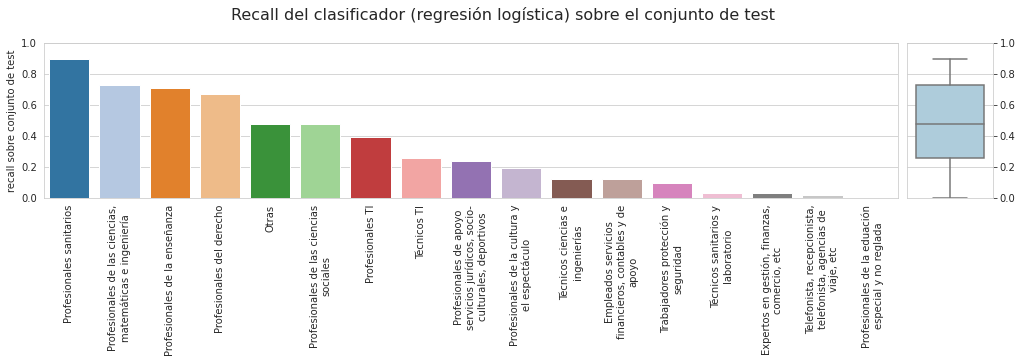

In [152]:
# Resultados recall modelo regresión logística (evaluación sobre test): 

sns.set_style('whitegrid')
fig= plt.figure(figsize=(17,5)) 
gs = gridspec.GridSpec(2,2, width_ratios=[10, 1],height_ratios=[5,3]) 
fig.suptitle('Recall del clasificador (regresión logística) sobre el conjunto de test',fontsize=16)

ax=plt.subplot(gs[0,0])
sns.barplot(data=recall_modelo,x='index',y='recall test',palette='tab20')
ax.set_xlabel('')
x_ticklabels=[textwrap.fill(tick.get_text(),30) for tick in ax.get_xticklabels()]
ax.set_xticklabels(x_ticklabels,rotation=90)
ax.set_ylim(0,1)
ax.set_ylabel('recall sobre conjunto de test')

ax=plt.subplot(gs[0,1])
sns.boxplot(data=recall_modelo,y='recall test',palette='Paired')
ax.set_ylim(0,1)
ax.tick_params(right=True,labelright=True,left=False,labelleft=False)
ax.set_ylabel('')

fig.subplots_adjust(wspace=0.02)

fig.savefig('img/recall_regresion_logistica.png',dpi=400)
plt.show()

# Conclusiones

Las métricas obtenidas por el modelo entrenado en el conjunto formado por los que hasta ahora habían sido los de entrenamiento y validación y evaluado en el conjunto de test son muy similares a los resultados obtenidos por el mejor modelo en la última fase de entrenamiento y validación. 

La principal diferencia entre ambos es que el modelo final no predice la ocupación Profesionales de la eduación especial y no reglada, que tenía unos resultados muy pobres en la fase de selección del modelo. Como esto solo se ha conocido en la evaluación final sobre el conjunto de test, no es apropiado incorporar esta ocupación a la categoría de 'otras' ocupaciones. Además, el modelo sí realiza predicciones acertadas para esta profesión en el conjunto de entrenamiento, por lo que se puede confiar en que sí pueda obtener resultados de predicción modestos pero positivos para un conjunto de test diferente. 

El modelo no sobreajusta. 

El modelo propuesto consigue mejorar el accuracy del modelo con regresor único en unos 5 puntos. La ganancia en relación con el modelo con varios regresores tomado como punto de partida es de 3.5 puntos. Por último, la ganancia de accuracy respecto al modelo previo a la selección de regresores y el contraste de proporciones es de unos 3 puntos. 

En resumen, las ganancias de predicción que se obtienen al tener en cuenta información de los encuestados distinta a su título principal son muy modestas. 

Se consiguen predecir con una tasa de aciertos positiva 15 de las 62 ocupaciones observadas (sin contar con el epígrafe 'otras'), las mismas que es capaz de predecir el modelo con el título principal como regresor único. La tasa de acierto esperada de un clasificador puramente aleatorio sobre 15 categorías distintas es aproximadamente del 7 %, muy inferior a la tasa de aciertos del 50 % que alcanza el modelo propuesto. Este es la cualidad más destacada del modelo. 

La reclasificación de ocupaciones implica renunciar a predecir las profesiones de unos 13000 encuestados (aproximadamente un 22 % de los encuestados ocupados). 

In [111]:
df[df['ocupacionR_']=='Otras'].shape[0]

13211

In [112]:
df[df['ocupacion'].notna()].shape[0]

59844

## Efecto de la inclusión del sexo como regresor adicional

In [113]:
# Mejor resultado de contraste de diferencia de proporciones: sobre 'familia_ppal', keep_regresores=True 

target='ocupacionR'

filtro_utilidad=False

# Regresores a codificar:
target_encoding=['familia_ppal_','ambito_g1_']
one_hot_encoding=['titulo_ppal_','rama_g2_','familia_ppal_']
umbral_te=0.01

# Se incluye el 'sexo' como regresor adicional: 
resto_regresores=resto_regresores+['sexo']

# Contraste proporciones: 
contraste_prop=['familia_ppal_']
keep_regresores=True
umbral_obs=60
umbral_p_valor=0.001

# Resto de regresores
resto_regresores

modelo=LR_contraste_proporciones_pipe(validacion=False)

In [114]:
report(modelo,X_test,y_test,name='test')

,weighted avg,Profesionales sanitarios,"Profesionales de las ciencias, matemáticas e ingeniería",Profesionales de la enseñanza,Profesionales del derecho,Otras,Profesionales de las ciencias sociales,Profesionales TI,Técnicos TI,"Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",Profesionales de la cultura y el espectáculo,"Empleados servicios financieros, contables y de apoyo",Técnicos ciencias e ingenierías,Trabajadores protección y seguridad,Técnicos sanitarios y laboratorio,"Expertos en gestión, finanzas, comercio, etc","Telefonista, recepcionista, telefonista, agencias de viaje, etc",Profesionales de la eduación especial y no reglada
precision test,0.472787,0.846107,0.476252,0.564706,0.465066,0.389888,0.436735,0.385445,0.311284,0.467105,0.338583,0.344633,0.315152,0.565217,0.250000,0.257576,0.545455,0.0
recall test,0.506141,0.895522,0.725081,0.709119,0.661491,0.476497,0.475556,0.383378,0.258065,0.241497,0.181435,0.128151,0.120370,0.086093,0.030928,0.030249,0.025532,0.0
f1-score test,0.466542,0.870113,0.574897,0.628726,0.546154,0.428864,0.455319,0.384409,0.282187,0.318386,0.236264,0.186830,0.174204,0.149425,0.055046,0.054140,0.048780,0.0
support test,11969.000000,1541.000000,1535.000000,1963.000000,322.000000,2638.000000,450.000000,373.000000,310.000000,294.000000,237.000000,476.000000,432.000000,151.000000,97.000000,562.000000,235.000000,353.0


In [115]:
X_train.head()

,n_g_ambito Medio ambiente,n_g_ambito Negocios y administración,g_medio: Sanidad,árabe_acred,n_g_ambito Formación de docentes de enseñanza infantil,tipo_centro,g_superior: Edificación y obra civil,g_medio: Servicios socioculturales y a la comunidad,alemán_acred,valenciano_nivel,n_g_ambito Psicología,euskera_nivel,n_g_ambito Informática,italiano_nivel,árabe,n_g_ambito Ciencias de la vida,n_g_ambito Arquitectura y construcción,g_medio: Administración y gestión,n_g_ambito Salud,n_g_ambito Industria manufacturera y producción,varios_titulos_u,g_medio: Electricidad y electrónica,portugués,catalán,chino_acred,n_art_hum,rumano_nivel,n_master,español_acred,n_g_ambito Lenguas,n_g_ambito Economía,n_g_ambito Ciencias sociales y del comportamiento,n_cc_salud,n_ciencias,g_medio: Instalación y mantenimiento,n_g_ambito Agricultura y ganadería,portugués_acred,inglés,n_g_ambito Actividades físicas y deportivas,"g_medio: Madera, mueble y corcho",tipo_docencia,n_cc_soc_ju,n_servicios,varios_master,g_superior: Comercio y marketing,doctor,n_gsup,n_g_ambito Ingeniería y profesiones afines,sexo,g_medio: Imagen y sonido,italiano_acred,gallego_nivel,g_medio: Fabricación mecánica,g_medio: Seguridad y medio ambiente,n_g_ambito Educación,valenciano,n_g_ambito Formación de docentes de enseñanza primaria,g_medio: Comercio y marketing,varios_grados,francés,n_g_ambito Técnicas audiovisuales y medios de comunicación,n_g_ambito Dirección y administración,g_medio: Edificación y obra civil,ti,n_g_ambito Humanidades,n_g_ambito Servicios,"n_g_ambito Viajes, turismo y ocio",catalán_acred,n_g_ambito Servicios sociales,n_g_ambito Artes,francés_acred,ruso,n_g_ambito Veterinaria,beca_colab,g_medio: Química,ruso_nivel,g_medio: Imagen personal,g_medio: Transporte y mantenimiento de vehículos,valenciano_acred,extr_proxy,g_medio: Actividades físicas y deportivas,n_g_ambito Medicina,alemán_nivel,español_nivel,g_medio: Industrias extractivas,g_medio: Hostelería y turismo,g_superior: Actividades físicas y deportivas,g_medio: Artes gráficas,g_superior: Sanidad,catalán_nivel,n_ing_arq,ruso_acred,gallego,n_g_ambito Derecho,n_g_ambito Periodismo y documentación,n_g_ambito Silvicultura,n_g_ambito Enfermería,n_g_ambito Matemáticas y estadística,euskera,g_medio: Informática y comunicaciones,euskera_acred,chino,g_medio: Enseñanzas artísticas profesionales,extr,alemán,g_medio: Marítimo-pesquera,f_Otras,f_Profesionales de la enseñanza,"f_Empleados servicios financieros, contables y de apoyo",f_Profesionales del derecho,f_Profesionales sanitarios,"f_Expertos en gestión, finanzas, comercio, etc","f_Profesionales de las ciencias, matemáticas e ingeniería",f_Profesionales de la eduación especial y no reglada,f_Profesionales de la cultura y el espectáculo,f_Técnicos TI,"f_Telefonista, recepcionista, telefonista, agencias de viaje, etc","f_Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",f_Técnicos ciencias e ingenierías,f_Trabajadores protección y seguridad,f_Profesionales de las ciencias sociales,f_Profesionales TI,f_Técnicos sanitarios y laboratorio,a_Otras,a_Profesionales de la enseñanza,"a_Empleados servicios financieros, contables y de apoyo",a_Profesionales de la eduación especial y no reglada,a_Profesionales de la cultura y el espectáculo,"a_Profesionales de apoyo servicios jurídicos, socio-culturales, deportivos",a_Profesionales del derecho,"a_Expertos en gestión, finanzas, comercio, etc",a_Profesionales de las ciencias sociales,"a_Telefonista, recepcionista, telefonista, agencias de viaje, etc",a_Profesionales TI,a_Trabajadores protección y seguridad,a_Técnicos ciencias e ingenierías,a_Profesionales sanitarios,"a_Profesionales de las ciencias, matemáticas e ingeniería",a_Técnicos sanitarios y laboratorio,a_Técnicos TI,titulo_ppal Grado Actividad física y del deporte,titulo_ppal Grado Administración y empresa,titulo_ppal Grado Antropología social y cultural y Estudios y gestión de la cultura,titulo_ppal Grado Arqueología,titulo_ppal Grado Arquitectura técnic

### Conclusiones:

La inclusión del sexo como variable explicativa no mejora la tasa de aciertos. Tampoco aparece como variable decisiva en ningún contraste de diferencias de proporciones (véanse las variables creadas cuando estas diferencias son significativas -columnas de X_train-). 

Se concluye que las diferencias en las ocupaciones que se observan para los dos sexos están reflejadas en el resto de regresores seleccionados. 

### Diccionario de ocupaciones reducido como csv: 

In [116]:
D_ocupaciones_reducido = pd.DataFrame.from_dict(D_target['ocupacionR'], orient='index',columns=['valor'])
D_ocupaciones_reducido.to_csv('data/D_ocupaciones_reducido.csv')